# Import Libraries

In [284]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, cohen_kappa_score, matthews_corrcoef, accuracy_score, make_scorer, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from keras.models import Sequential, Model, save_model, load_model
from keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, Dropout, BatchNormalization, Embedding, LSTM
from lightgbm import LGBMClassifier
from rotation_forest import RotationForestClassifier
from keras.utils import to_categorical
import tensorflow as tf
from keras import backend as K
from keras import backend
import random
import os

from xgboost import XGBClassifier

# Necessary Functions

In [62]:
def ROC_AUC_PLOT(y_test, y_pred):
    fpr, tpr, _ = roc_curve(y_test,  y_pred[:, 1])
    auc = roc_auc_score(y_test, y_pred[:, 1])
    plt.plot([0, 1], [0, 1], linestyle='dashed', color='black')
    plt.plot(fpr, tpr, label="AUC : "+str(auc))
    plt.legend(loc=4)
    plt.xlabel('1-Specificity')
    plt.ylabel('Sensitivity')
    plt.show()

def ROC_AUC_PLOT_ALL(y_test, pred):
    for p in pred:
        fpr, tpr, _ = roc_curve(y_test,  p[1][:, 1])
        auc = "{:.4f}".format(roc_auc_score(y_test, p[1][:, 1]))
        plt.plot([0, 1], [0, 1], linestyle='dashed', color='black')
        plt.plot(fpr, tpr, label=f'{p[0]} (AUC = {auc})')
    plt.legend(loc=4)
    plt.xlabel('1-Specificity')
    plt.ylabel('Sensitivity')
    plt.show()

def show_results(y_test, pred):
    y_pred = np.argmax(pred, axis=1)
    print(classification_report(y_test, y_pred))
    print(f'MCC : {matthews_corrcoef(y_test, y_pred)}')
    print(f'Kappa : {cohen_kappa_score(y_test, y_pred)}')

    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g')
    plt.xlabel('Reference')
    plt.ylabel('Prediction')
    plt.show()

    ROC_AUC_PLOT(y_test, pred)

def ExtractFragments(sequence, window_size):
    fragments = []
    size = (window_size - 1) // 2
    for i in range(len(sequence)):
        if sequence[i] == 'K':
            fragment = sequence[i - size: i + size + 1]
            if len(fragment) < window_size:
                continue
            fragments.append((fragment, i))
    return fragments

def ExtractFeatures(df, window_size=5, path='train'):

    indexes = np.unique(df['Uniprot Accession'], return_index=True)[1]
    seq_name = [df['Uniprot Accession'][index] for index in sorted(indexes)]

    # seq_name = np.unique(df['Uniprot Accession'])
    sequences = []
    positions = []

    for i in range(len(seq_name)):
        seq = df[df['Uniprot Accession'] == seq_name[i]]['Sequence'].values[0]
        position = df[df['Uniprot Accession'] == seq_name[i]]['Position'].values
        sequences.append(seq)
        positions.append(position)

    FeatureMatrix_POS = []
    FeatureMatrix_NEG = []

    for i, fasta in enumerate(sequences):
        print(f'{i}/{len(sequences)}')
        pos_index = positions[i] - 1
        fragments = ExtractFragments(fasta, window_size)
        for fragment in fragments:
            if fragment[1] in pos_index:
                FeatureMatrix_POS.append(np.concatenate((fragment, [1])))
            else:
                FeatureMatrix_NEG.append(np.concatenate((fragment, [0])))
    
    FM = pd.DataFrame(FeatureMatrix_POS + FeatureMatrix_NEG)

    return FM


# Configurations

In [9]:
WINDOW_SIZE = 35
MAX_NB_WORDS=35

# Load Datasets

In [266]:
scaler = StandardScaler()

eaac_train = pd.read_csv(f'features/eaac_train_{WINDOW_SIZE}.csv')
eaac_test = pd.read_csv(f'features/eaac_test_{WINDOW_SIZE}.csv')

y_train = eaac_train.iloc[:, -1]
y_test = eaac_test.iloc[:, -1]

eaac_train = scaler.fit_transform(eaac_train.iloc[:, :-1])
eaac_test = scaler.transform(eaac_test.iloc[:, :-1])

egaac_train = pd.read_csv(f'features/egaac_train_{WINDOW_SIZE}.csv')
egaac_test = pd.read_csv(f'features/egaac_test_{WINDOW_SIZE}.csv')
egaac_train = scaler.fit_transform(egaac_train.iloc[:, :-1])
egaac_test = scaler.transform(egaac_test.iloc[:, :-1])

blo_train = pd.read_csv(f'features/blo_train_{WINDOW_SIZE}.csv')
blo_test = pd.read_csv(f'features/blo_test_{WINDOW_SIZE}.csv')
blo_train = scaler.fit_transform(blo_train.iloc[:, :-1])
blo_test = scaler.transform(blo_test.iloc[:, :-1])

pssm_train = pd.read_csv(f'features/pssm_train_{WINDOW_SIZE}.csv')
pssm_test = pd.read_csv(f'features/pssm_test_{WINDOW_SIZE}.csv')
pssm_train = scaler.fit_transform(pssm_train.iloc[:, :-1])
pssm_test = scaler.transform(pssm_test.iloc[:, :-1])

dde_train = pd.read_csv(f'features/dde_train_{WINDOW_SIZE}.csv')
dde_test = pd.read_csv(f'features/dde_test_{WINDOW_SIZE}.csv')
dde_train = scaler.fit_transform(dde_train.iloc[:, :-1])
dde_test = scaler.transform(dde_test.iloc[:, :-1])

bin_train = pd.read_csv(f'features/bina_train_{WINDOW_SIZE}.csv')
bin_test = pd.read_csv(f'features/bina_test_{WINDOW_SIZE}.csv')
bin_train = scaler.fit_transform(bin_train.iloc[:, :-1])
bin_test = scaler.transform(bin_test.iloc[:, :-1])

aac_train = pd.read_csv(f'features/aac_train_{WINDOW_SIZE}.csv')
aac_test = pd.read_csv(f'features/aac_test_{WINDOW_SIZE}.csv')
aac_train = scaler.fit_transform(aac_train.iloc[:, :-1])
aac_test = scaler.transform(aac_test.iloc[:, :-1])

pcp_train = pd.read_csv(f'features/pcp_train_{WINDOW_SIZE}.csv')
pcp_test = pd.read_csv(f'features/pcp_test_{WINDOW_SIZE}.csv')
pcp_train = scaler.fit_transform(pcp_train.iloc[:, :-1])
pcp_test = scaler.transform(pcp_test.iloc[:, :-1])

paac_train = pd.read_csv(f'features/paac_train_{WINDOW_SIZE}.csv')
paac_test = pd.read_csv(f'features/paac_test_{WINDOW_SIZE}.csv')

knn_train = pd.read_csv(f'features/knn_train_{WINDOW_SIZE}.csv')
knn_train = knn_train.iloc[:, 2:]
knn_test = pd.read_csv(f'features/knn_test_{WINDOW_SIZE}.csv')
knn_test = knn_test.iloc[:, 2:]
knn_train = scaler.fit_transform(knn_train)
knn_test = scaler.transform(knn_test)

In [11]:
df_train = pd.read_excel('dataset/Train.xlsx')
df_test = pd.read_excel('dataset/Test.xlsx')

FM_train = ExtractFeatures(df_train, window_size=WINDOW_SIZE)
FM_test = ExtractFeatures(df_test, window_size=WINDOW_SIZE, path='test')

FM_train['chars'] = FM_train[0].apply(lambda text: [*text])
FM_test['chars'] = FM_test[0].apply(lambda text: [*text])

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True)
tokenizer.fit_on_texts(FM_train['chars'].values)
word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens.')

token_train = tokenizer.texts_to_sequences(FM_train['chars'].values)
token_test = tokenizer.texts_to_sequences(FM_test['chars'].values)

rus = RandomUnderSampler(random_state=0)
token_train, _ = rus.fit_resample(token_train, FM_train[2].values.astype('int'))
token_test, _ = rus.fit_resample(token_test, FM_test[2].values.astype('int'))

0/2107
1/2107
2/2107
3/2107
4/2107
5/2107
6/2107
7/2107
8/2107
9/2107
10/2107
11/2107
12/2107
13/2107
14/2107
15/2107
16/2107
17/2107
18/2107
19/2107
20/2107
21/2107
22/2107
23/2107
24/2107
25/2107
26/2107
27/2107
28/2107
29/2107
30/2107
31/2107
32/2107
33/2107
34/2107
35/2107
36/2107
37/2107
38/2107
39/2107
40/2107
41/2107
42/2107
43/2107
44/2107
45/2107
46/2107
47/2107
48/2107
49/2107
50/2107
51/2107
52/2107
53/2107
54/2107
55/2107
56/2107
57/2107
58/2107
59/2107
60/2107
61/2107
62/2107
63/2107
64/2107
65/2107
66/2107
67/2107
68/2107
69/2107
70/2107
71/2107
72/2107
73/2107
74/2107
75/2107
76/2107
77/2107
78/2107
79/2107
80/2107
81/2107
82/2107
83/2107
84/2107
85/2107
86/2107
87/2107
88/2107
89/2107
90/2107
91/2107
92/2107
93/2107
94/2107
95/2107
96/2107
97/2107
98/2107
99/2107
100/2107
101/2107
102/2107
103/2107
104/2107
105/2107
106/2107
107/2107
108/2107
109/2107
110/2107
111/2107
112/2107
113/2107
114/2107
115/2107
116/2107
117/2107
118/2107
119/2107
120/2107
121/2107
122/2107
123

# 1) Parameter Tuning

In [16]:
x_train = np.concatenate([eaac_train, egaac_train, blo_train, pssm_train], axis=1)
x_test = np.concatenate([eaac_test, egaac_test, blo_test, pssm_test], axis=1)

### XGB

In [33]:
baseXGB = XGBClassifier(verbose=1, random_state=0)

params = {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [2, 3, 5, 6]
}

searchXGB = GridSearchCV(baseXGB, params, cv=3, verbose=1)

In [34]:
searchXGB.fit(x_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[14:49:04] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[14:49:09] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[14:49:13] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[14:49:18] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[14:49:26] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/learner.cc:7

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=0, ...),
             param_grid={'max_depth': [2, 3, 5, 6],
                         'n_estimators': [100, 200, 500, 1000]},
             verbose=1)

In [35]:
searchXGB.best_params_

{'max_depth': 5, 'n_estimators': 1000}

### RF

In [38]:
baseRF = RandomForestClassifier(verbose=1, random_state=0)

params = {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [2, 3, 5, 6],
    'min_samples_split': [10, 30, 50]
}

searchRF = GridSearchCV(baseRF, params, cv=3, verbose=1)

In [39]:
searchRF.fit(x_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=0, verbose=1),
             param_grid={'max_depth': [2, 3, 5, 6],
                         'min_samples_split': [10, 30, 50],
                         'n_estimators': [100, 200, 500, 1000]},
             verbose=1)

In [40]:
searchRF.best_params_

{'max_depth': 6, 'min_samples_split': 10, 'n_estimators': 1000}

### SVM

In [45]:
baseSVM = SVC(verbose=1, random_state=0)

params = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']
}

searchSVM = GridSearchCV(baseSVM, params, cv=3, verbose=1)

In [46]:
searchSVM.fit(x_train, y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

GridSearchCV(cv=3, estimator=SVC(random_state=0, verbose=1),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=1)

In [47]:
searchSVM.best_params_

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

### KNN

In [50]:
baseKNN = KNeighborsClassifier()

params = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'leaf_size': list(range(1, 11))
}

searchKNN = GridSearchCV(baseKNN, params, cv=3, verbose=1)

In [51]:
searchKNN.fit(x_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'n_neighbors': [3, 5, 7, 9, 11]},
             verbose=1)

In [52]:
searchKNN.best_params_

{'leaf_size': 1, 'n_neighbors': 11}

In [53]:
searchKNN.best_score_

0.5553186448708837

# 2) Single Feature results

## I. Independent Set

### XBG

#### Feature Vector 1 : EAAC

In [56]:
xgb_eaac = XGBClassifier(n_estimators=1000, max_depth=5, verbose=1, random_state=0)

xgb_eaac.fit(eaac_train, y_train)

pred_xgb_eaac = xgb_eaac.predict_proba(eaac_test)

[17:29:20] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "verbose" } are not used.



              precision    recall  f1-score   support

         0.0       0.72      0.63      0.67       568
         1.0       0.67      0.76      0.71       568

    accuracy                           0.69      1136
   macro avg       0.70      0.69      0.69      1136
weighted avg       0.70      0.69      0.69      1136

MCC : 0.3869239995808129
Kappa : 0.3838028169014085


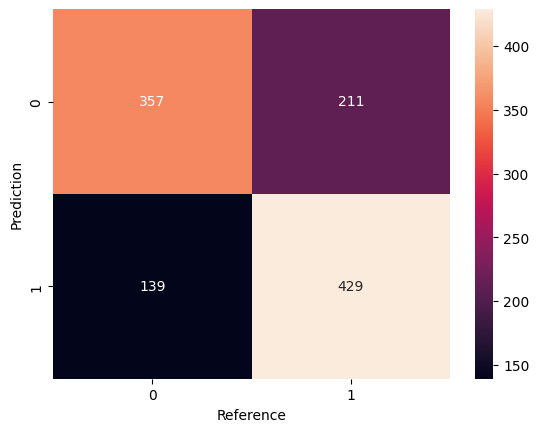

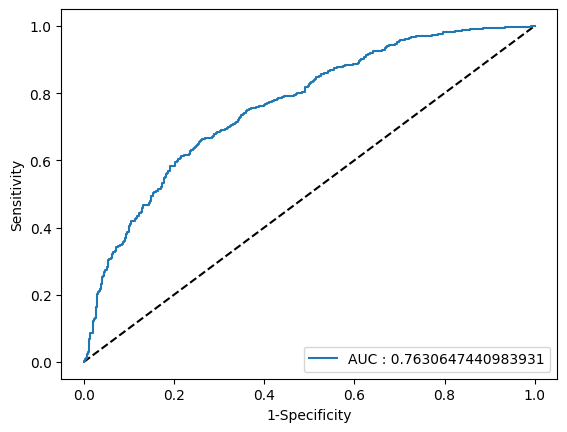

In [61]:
show_results(y_test, pred_xgb_eaac)

#### Feature Vector 2 : EGAAC

In [63]:
xgb_egaac = XGBClassifier(n_estimators=1000, max_depth=5, verbose=1, random_state=0)

xgb_egaac.fit(egaac_train, y_train)

pred_xgb_egaac = xgb_egaac.predict_proba(egaac_test)

[17:38:06] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "verbose" } are not used.



              precision    recall  f1-score   support

         0.0       0.71      0.63      0.67       568
         1.0       0.67      0.74      0.70       568

    accuracy                           0.69      1136
   macro avg       0.69      0.69      0.69      1136
weighted avg       0.69      0.69      0.69      1136

MCC : 0.37747983444352623
Kappa : 0.375


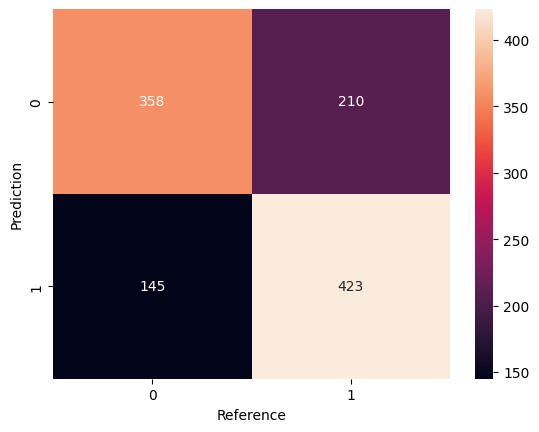

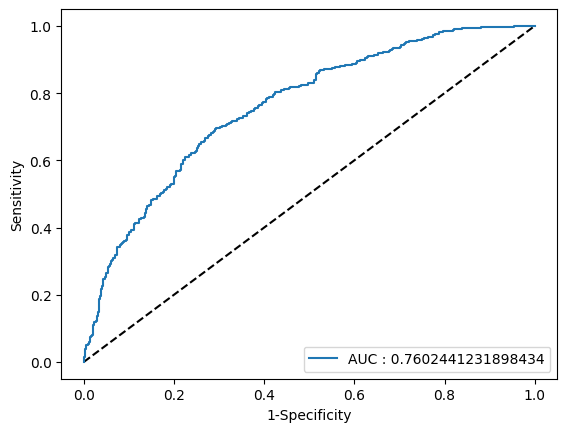

In [64]:
show_results(y_test, pred_xgb_egaac)

#### Feature Vector 3 : BLOSUM62

In [82]:
xgb_blo = XGBClassifier(n_estimators=1000, max_depth=5, verbose=1, random_state=0)

xgb_blo.fit(blo_train, y_train)

pred_xgb_blo = xgb_blo.predict_proba(blo_test)

[17:52:40] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "verbose" } are not used.



              precision    recall  f1-score   support

         0.0       0.69      0.59      0.64       568
         1.0       0.64      0.74      0.69       568

    accuracy                           0.66      1136
   macro avg       0.67      0.66      0.66      1136
weighted avg       0.67      0.66      0.66      1136

MCC : 0.3312840683766444
Kappa : 0.3274647887323944


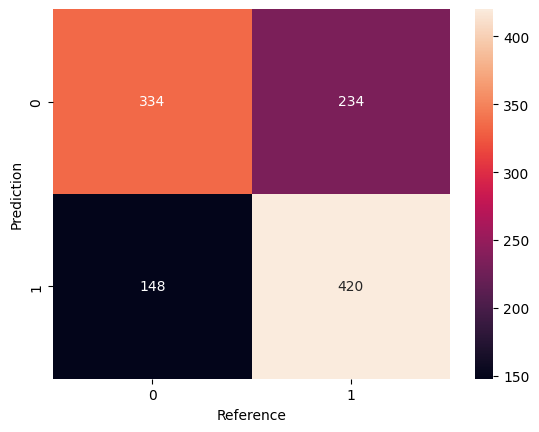

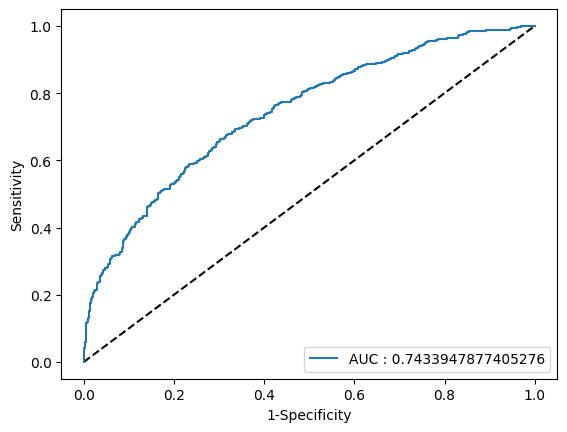

In [83]:
show_results(y_test, pred_xgb_blo)

#### Feature Vector 4 : PSSM

In [67]:
xgb_pssm = XGBClassifier(n_estimators=1000, max_depth=5, verbose=1, random_state=0)

xgb_pssm.fit(pssm_train, y_train)

pred_xgb_pssm = xgb_pssm.predict_proba(pssm_test)

[17:40:26] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "verbose" } are not used.



              precision    recall  f1-score   support

         0.0       0.67      0.55      0.60       568
         1.0       0.62      0.73      0.67       568

    accuracy                           0.64      1136
   macro avg       0.64      0.64      0.64      1136
weighted avg       0.64      0.64      0.64      1136

MCC : 0.2810683316914017
Kappa : 0.2764084507042254


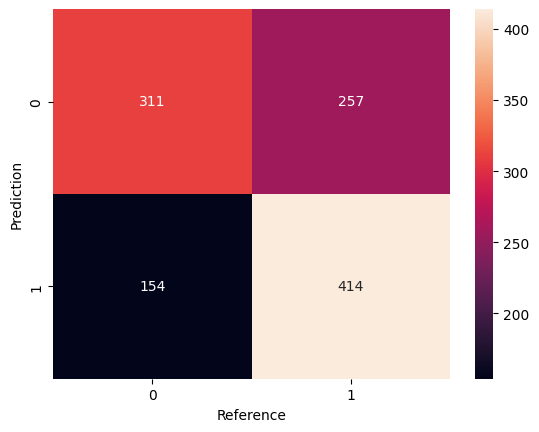

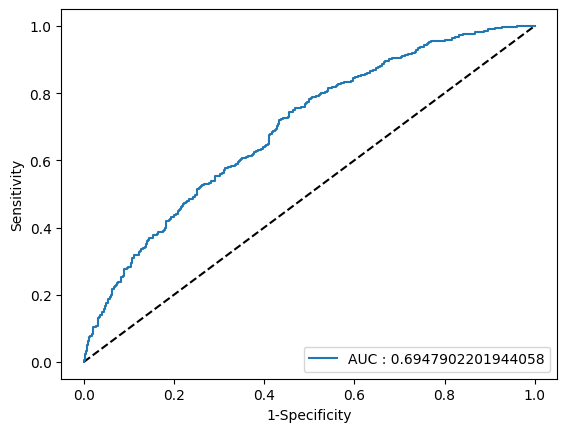

In [68]:
show_results(y_test, pred_xgb_pssm)

#### Feature Vector 5 : All

In [69]:
xgb_all = XGBClassifier(n_estimators=1000, max_depth=5, verbose=1, random_state=0)

xgb_all.fit(x_train, y_train)

pred_xgb = xgb_all.predict_proba(x_test)

[17:42:15] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "verbose" } are not used.



              precision    recall  f1-score   support

         0.0       0.76      0.62      0.68       568
         1.0       0.68      0.80      0.73       568

    accuracy                           0.71      1136
   macro avg       0.72      0.71      0.71      1136
weighted avg       0.72      0.71      0.71      1136

MCC : 0.4245709918869685
Kappa : 0.4172535211267606


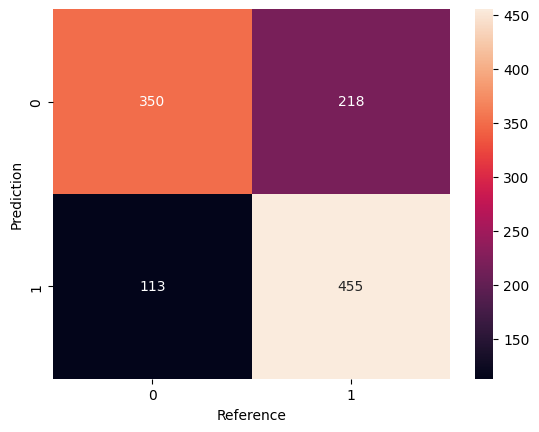

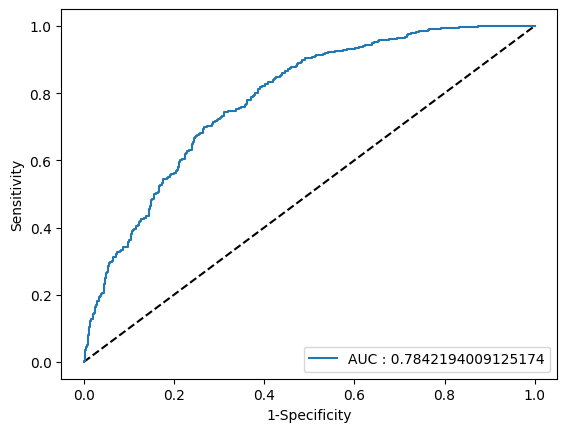

In [70]:
show_results(y_test, pred_xgb)

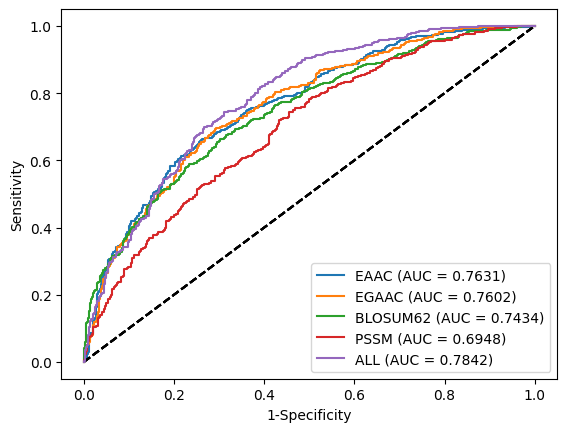

In [172]:
preds = [
    ['EAAC', pred_xgb_eaac],
    ['EGAAC', pred_xgb_egaac],
    ['BLOSUM62', pred_xgb_blo],
    ['PSSM', pred_xgb_pssm],
    ['ALL', pred_xgb]
]

ROC_AUC_PLOT_ALL(y_test, preds)

### RF

#### Feature Vector 1 : EAAC

In [75]:
rf_eaac = RandomForestClassifier(max_depth=6, min_samples_split=10, n_estimators=1000, verbose=1, random_state=0)

rf_eaac.fit(eaac_train, y_train)

pred_rf_eaac = rf_eaac.predict_proba(eaac_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    8.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


              precision    recall  f1-score   support

         0.0       0.67      0.57      0.62       568
         1.0       0.63      0.72      0.67       568

    accuracy                           0.65      1136
   macro avg       0.65      0.65      0.64      1136
weighted avg       0.65      0.65      0.64      1136

MCC : 0.2958254607907043
Kappa : 0.2922535211267606


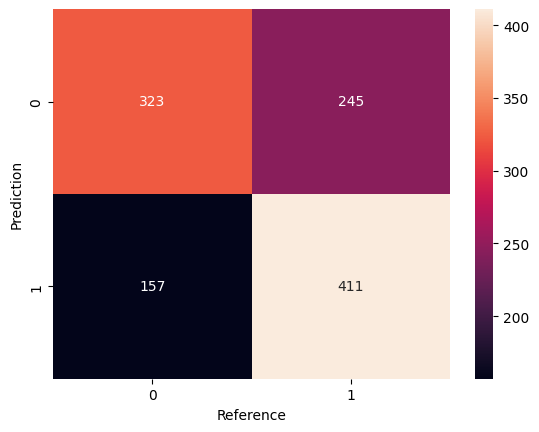

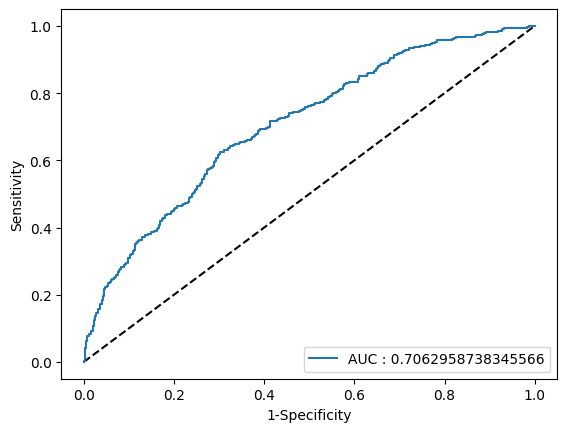

In [76]:
show_results(y_test, pred_rf_eaac)

#### Feature Vector 2 : EGAAC

In [77]:
rf_egaac = RandomForestClassifier(max_depth=6, min_samples_split=10, n_estimators=1000, verbose=1, random_state=0)

rf_egaac.fit(egaac_train, y_train)

pred_rf_egaac = rf_egaac.predict_proba(egaac_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    7.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


              precision    recall  f1-score   support

         0.0       0.70      0.57      0.62       568
         1.0       0.63      0.75      0.69       568

    accuracy                           0.66      1136
   macro avg       0.66      0.66      0.66      1136
weighted avg       0.66      0.66      0.66      1136

MCC : 0.3242504199643093
Kappa : 0.3186619718309859


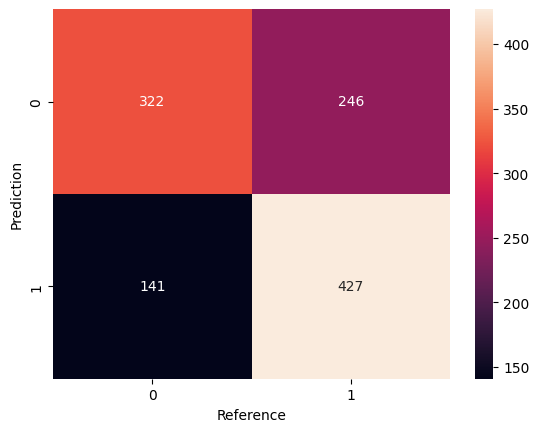

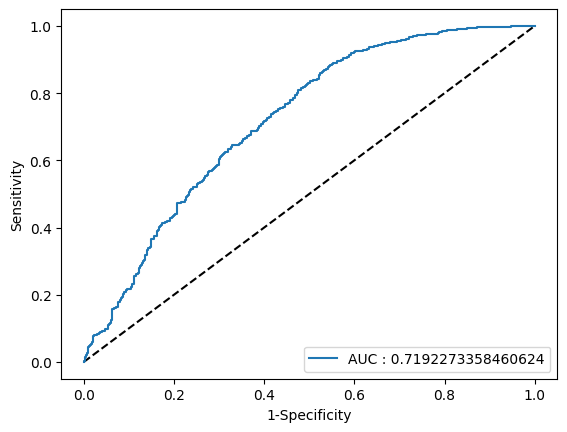

In [78]:
show_results(y_test, pred_rf_egaac)

#### Feature Vector 3 : BLOSUM62

In [80]:
rf_blo = RandomForestClassifier(max_depth=6, min_samples_split=10, n_estimators=1000, verbose=1, random_state=0)

rf_blo.fit(blo_train, y_train)

pred_rf_blo = rf_blo.predict_proba(blo_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   16.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


              precision    recall  f1-score   support

         0.0       0.66      0.46      0.54       568
         1.0       0.58      0.76      0.66       568

    accuracy                           0.61      1136
   macro avg       0.62      0.61      0.60      1136
weighted avg       0.62      0.61      0.60      1136

MCC : 0.22853503204009057
Kappa : 0.21830985915492962


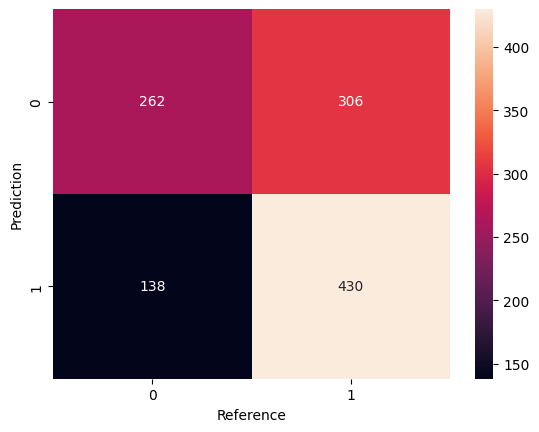

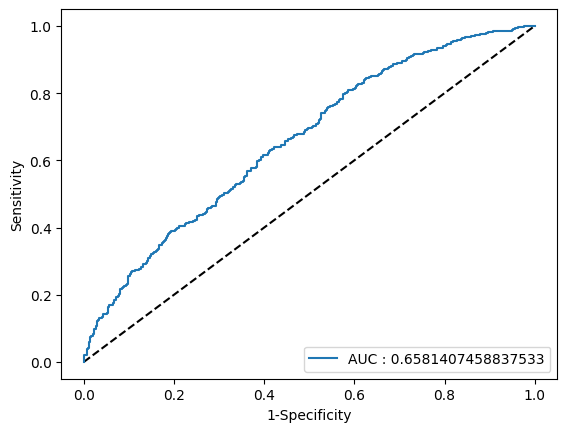

In [81]:
show_results(y_test, pred_rf_blo)

#### Feature Vector 4 : PSSM

In [88]:
rf_pssm = RandomForestClassifier(max_depth=6, min_samples_split=10, n_estimators=1000, verbose=1, random_state=0)

rf_pssm.fit(pssm_train, y_train)

pred_rf_pssm = rf_pssm.predict_proba(pssm_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   20.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


              precision    recall  f1-score   support

         0.0       0.62      0.39      0.48       568
         1.0       0.55      0.76      0.64       568

    accuracy                           0.57      1136
   macro avg       0.59      0.57      0.56      1136
weighted avg       0.59      0.57      0.56      1136

MCC : 0.15965196878801924
Kappa : 0.147887323943662


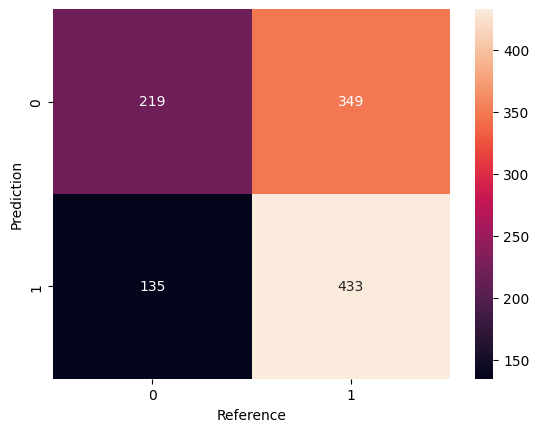

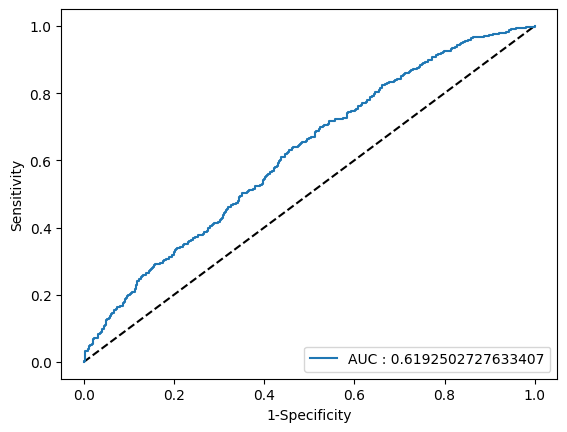

In [89]:
show_results(y_test, pred_rf_pssm)

#### Feature Vector 5 : All

In [90]:
rf_all = RandomForestClassifier(max_depth=6, min_samples_split=10, n_estimators=1000, verbose=1, random_state=0)

rf_all.fit(x_train, y_train)

pred_rf = rf_all.predict_proba(x_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   26.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


              precision    recall  f1-score   support

         0.0       0.68      0.52      0.59       568
         1.0       0.61      0.76      0.68       568

    accuracy                           0.64      1136
   macro avg       0.65      0.64      0.63      1136
weighted avg       0.65      0.64      0.63      1136

MCC : 0.28481736146285624
Kappa : 0.2764084507042254


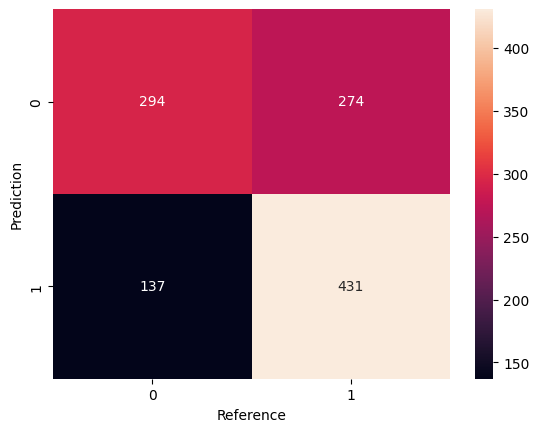

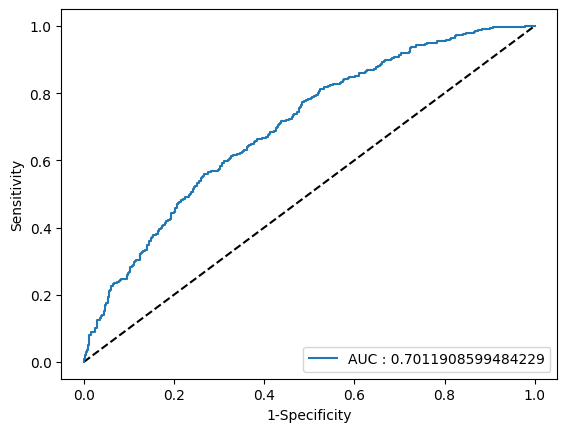

In [91]:
show_results(y_test, pred_rf)

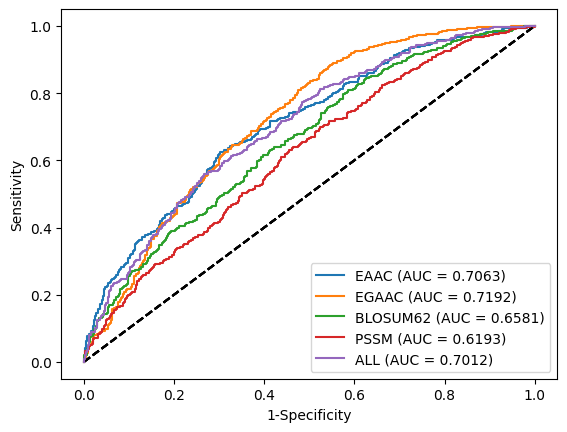

In [173]:
preds = [
    ['EAAC', pred_rf_eaac],
    ['EGAAC', pred_rf_egaac],
    ['BLOSUM62', pred_rf_blo],
    ['PSSM', pred_rf_pssm],
    ['ALL', pred_rf]
]

ROC_AUC_PLOT_ALL(y_test, preds)

### SVM

#### Feature Vector 1 : EAAC

In [93]:
svm_eaac = SVC(C=10, gamma=0.001, kernel='rbf', verbose=1, probability=True, random_state=0)

svm_eaac.fit(eaac_train, y_train)

pred_svm_eaac = svm_eaac.predict_proba(eaac_test)

[LibSVM]

              precision    recall  f1-score   support

         0.0       0.65      0.60      0.62       568
         1.0       0.63      0.68      0.66       568

    accuracy                           0.64      1136
   macro avg       0.64      0.64      0.64      1136
weighted avg       0.64      0.64      0.64      1136

MCC : 0.2827013970960878
Kappa : 0.2816901408450704


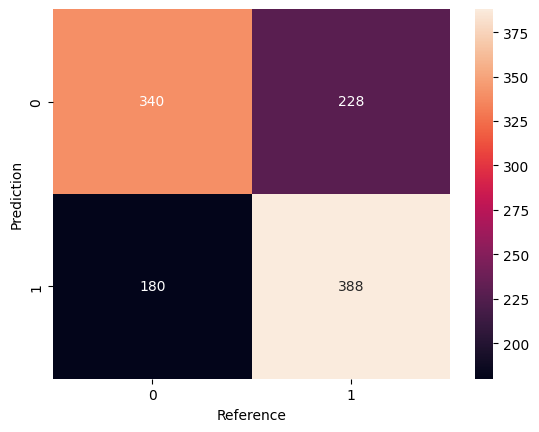

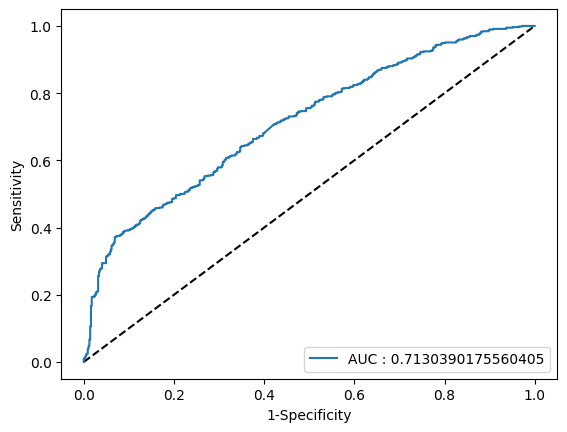

In [94]:
show_results(y_test, pred_svm_eaac)

#### Feature Vector 2 : EGAAC

In [95]:
svm_egaac = SVC(C=10, gamma=0.001, kernel='rbf', verbose=1, probability=True, random_state=0)

svm_egaac.fit(egaac_train, y_train)

pred_svm_egaac = svm_egaac.predict_proba(egaac_test)

[LibSVM]

              precision    recall  f1-score   support

         0.0       0.68      0.59      0.63       568
         1.0       0.64      0.72      0.68       568

    accuracy                           0.66      1136
   macro avg       0.66      0.66      0.65      1136
weighted avg       0.66      0.66      0.65      1136

MCC : 0.3143723346022925
Kappa : 0.31161971830985913


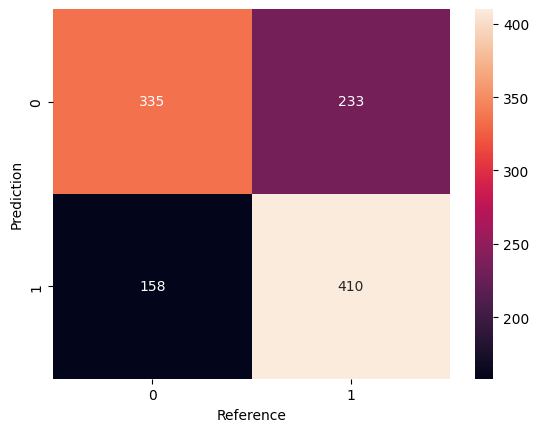

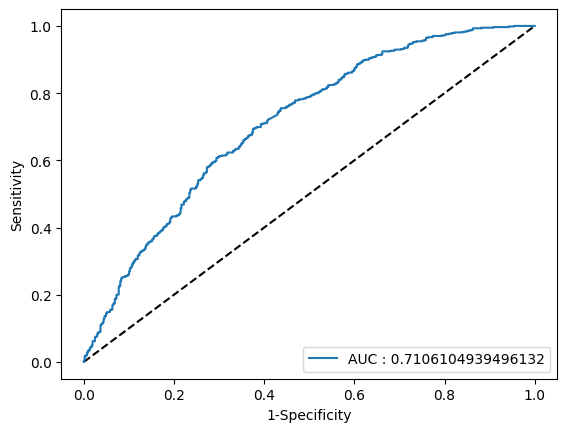

In [96]:
show_results(y_test, pred_svm_egaac)

#### Feature Vector 3 : BLOSUM62

In [97]:
svm_blo = SVC(C=10, gamma=0.001, kernel='rbf', verbose=1, probability=True, random_state=0)

svm_blo.fit(blo_train, y_train)

pred_svm_blo = svm_blo.predict_proba(blo_test)

[LibSVM]

              precision    recall  f1-score   support

         0.0       0.67      0.60      0.64       568
         1.0       0.64      0.70      0.67       568

    accuracy                           0.65      1136
   macro avg       0.66      0.65      0.65      1136
weighted avg       0.66      0.65      0.65      1136

MCC : 0.3096617686426662
Kappa : 0.30809859154929575


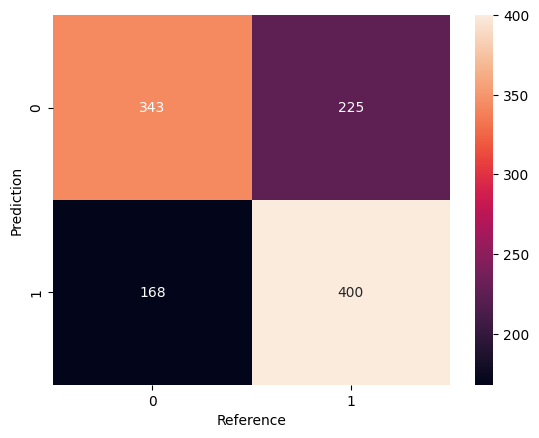

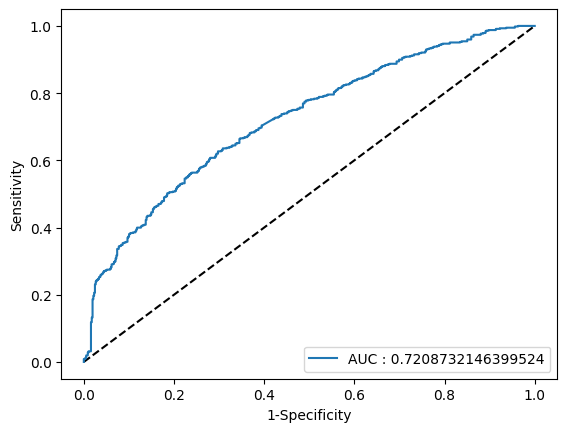

In [98]:
show_results(y_test, pred_svm_blo)

#### Feature Vector 4 : PSSM

In [99]:
svm_pssm = SVC(C=10, gamma=0.001, kernel='rbf', verbose=1, probability=True, random_state=0)

svm_pssm.fit(pssm_train, y_train)

pred_svm_pssm = svm_pssm.predict_proba(pssm_test)

[LibSVM]

              precision    recall  f1-score   support

         0.0       0.67      0.57      0.61       568
         1.0       0.62      0.71      0.67       568

    accuracy                           0.64      1136
   macro avg       0.64      0.64      0.64      1136
weighted avg       0.64      0.64      0.64      1136

MCC : 0.28637760124173706
Kappa : 0.2834507042253521


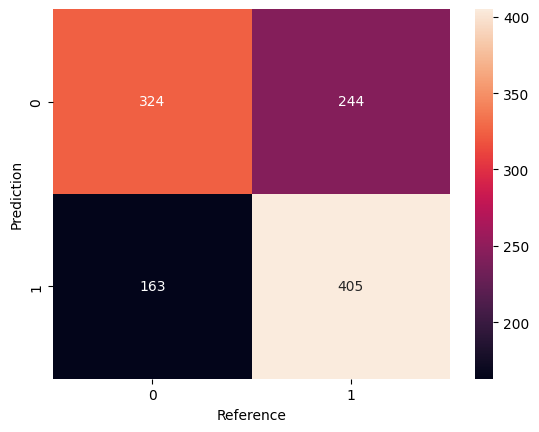

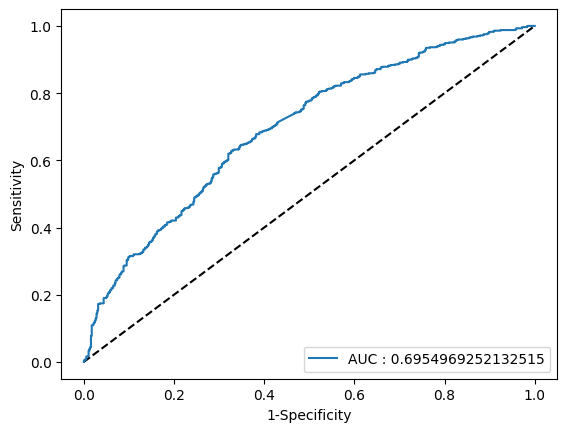

In [100]:
show_results(y_test, pred_svm_pssm)

#### Feature Vector 5 : All

In [101]:
svm_all = SVC(C=10, gamma=0.001, kernel='rbf', verbose=1, probability=True, random_state=0)

svm_all.fit(x_train, y_train)

pred_svm = svm_all.predict_proba(x_test)

[LibSVM]

              precision    recall  f1-score   support

         0.0       0.74      0.55      0.63       568
         1.0       0.64      0.80      0.71       568

    accuracy                           0.68      1136
   macro avg       0.69      0.68      0.67      1136
weighted avg       0.69      0.68      0.67      1136

MCC : 0.3672970121755391
Kappa : 0.3556338028169014


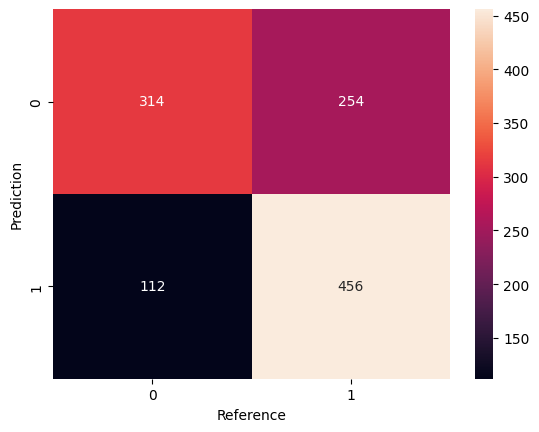

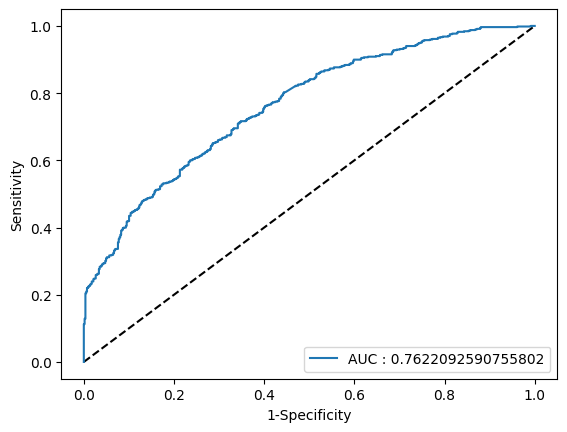

In [102]:
show_results(y_test, pred_svm)

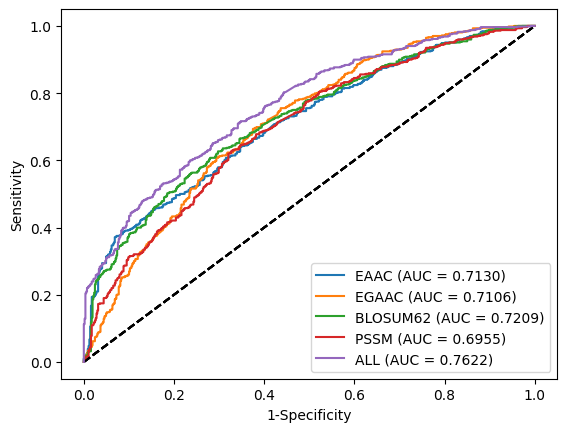

In [174]:
preds = [
    ['EAAC', pred_svm_eaac],
    ['EGAAC', pred_svm_egaac],
    ['BLOSUM62', pred_svm_blo],
    ['PSSM', pred_svm_pssm],
    ['ALL', pred_svm]
]

ROC_AUC_PLOT_ALL(y_test, preds)

### KNN

#### Feature Vector 1 : EAAC

In [103]:
knn_eaac = KNeighborsClassifier(leaf_size=1, n_neighbors=11)

knn_eaac.fit(eaac_train, y_train)

pred_knn_eaac = knn_eaac.predict_proba(eaac_test)

              precision    recall  f1-score   support

         0.0       0.61      0.42      0.50       568
         1.0       0.56      0.73      0.63       568

    accuracy                           0.57      1136
   macro avg       0.58      0.57      0.56      1136
weighted avg       0.58      0.57      0.56      1136

MCC : 0.15517288448251543
Kappa : 0.147887323943662


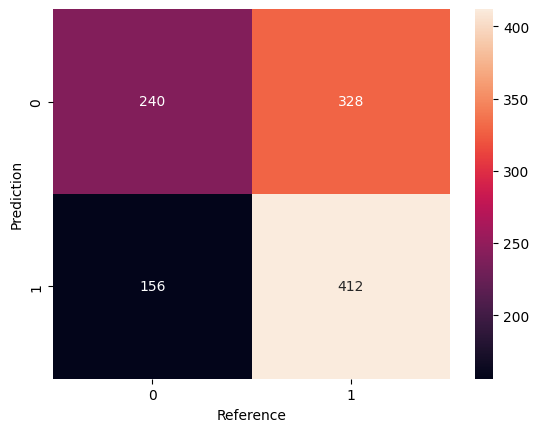

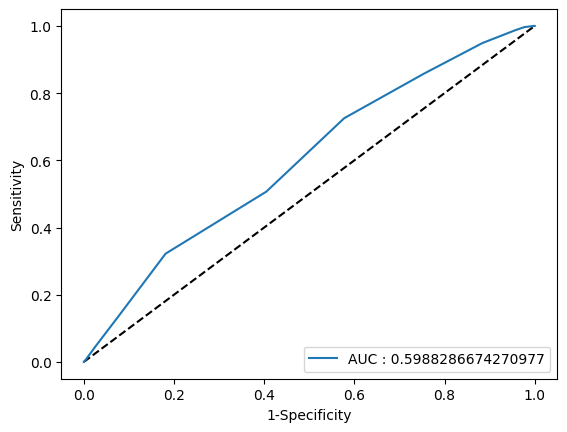

In [104]:
show_results(y_test, pred_knn_eaac)

#### Feature Vector 2 : EGAAC

In [105]:
knn_egaac = KNeighborsClassifier(leaf_size=1, n_neighbors=11)

knn_egaac.fit(egaac_train, y_train)

pred_knn_egaac = knn_egaac.predict_proba(egaac_test)

              precision    recall  f1-score   support

         0.0       0.68      0.48      0.57       568
         1.0       0.60      0.77      0.68       568

    accuracy                           0.63      1136
   macro avg       0.64      0.63      0.62      1136
weighted avg       0.64      0.63      0.62      1136

MCC : 0.2684767195838447
Kappa : 0.25704225352112675


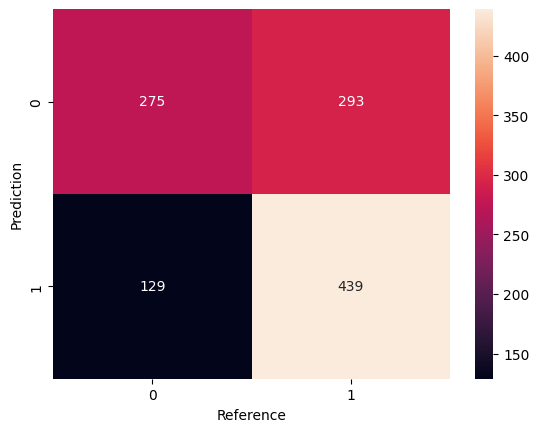

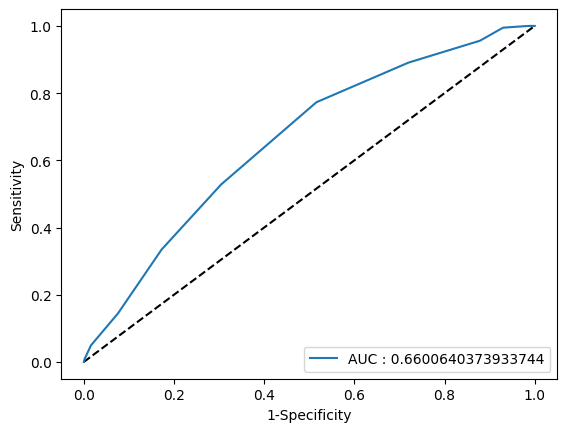

In [106]:
show_results(y_test, pred_knn_egaac)

#### Feature Vector 3 : BLOSUM62

In [107]:
knn_blo = KNeighborsClassifier(leaf_size=1, n_neighbors=11)

knn_blo.fit(blo_train, y_train)

pred_knn_blo = knn_blo.predict_proba(blo_test)

              precision    recall  f1-score   support

         0.0       0.54      0.57      0.56       568
         1.0       0.55      0.52      0.53       568

    accuracy                           0.54      1136
   macro avg       0.54      0.54      0.54      1136
weighted avg       0.54      0.54      0.54      1136

MCC : 0.08639637602546395
Kappa : 0.08626760563380287


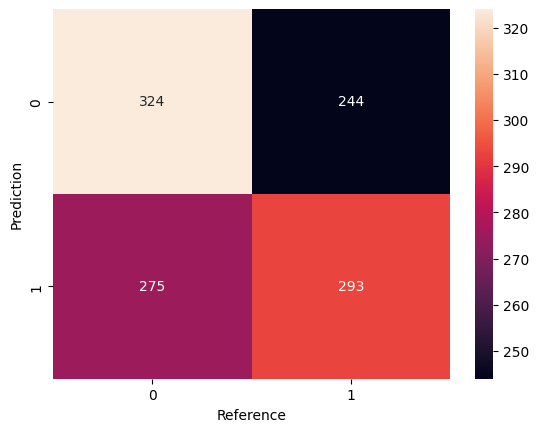

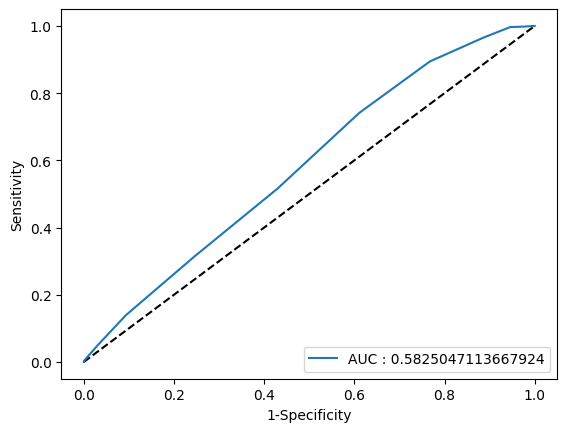

In [108]:
show_results(y_test, pred_knn_blo)

#### Feature Vector 4 : PSSM

In [109]:
knn_pssm = KNeighborsClassifier(leaf_size=1, n_neighbors=11)

knn_pssm.fit(pssm_train, y_train)

pred_knn_pssm = knn_pssm.predict_proba(pssm_test)

              precision    recall  f1-score   support

         0.0       0.54      0.75      0.63       568
         1.0       0.59      0.37      0.45       568

    accuracy                           0.56      1136
   macro avg       0.57      0.56      0.54      1136
weighted avg       0.57      0.56      0.54      1136

MCC : 0.12583418491723178
Kappa : 0.1161971830985915


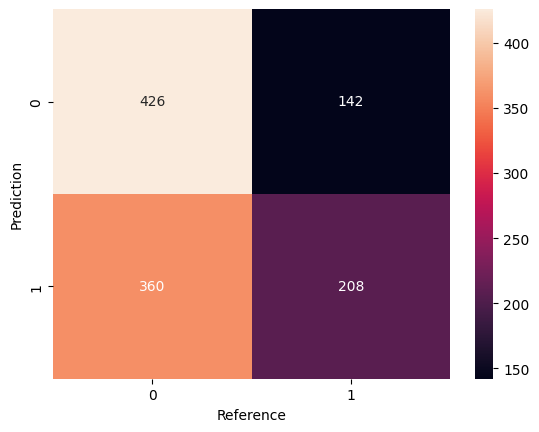

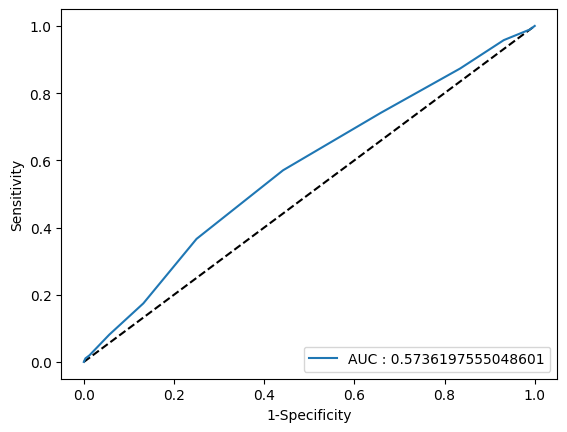

In [110]:
show_results(y_test, pred_knn_pssm)

#### Feature Vector 5 : All

In [111]:
knn_all = KNeighborsClassifier(leaf_size=1, n_neighbors=11)

knn_all.fit(x_train, y_train)

pred_knn = knn_all.predict_proba(x_test)

              precision    recall  f1-score   support

         0.0       0.61      0.64      0.63       568
         1.0       0.62      0.59      0.61       568

    accuracy                           0.62      1136
   macro avg       0.62      0.62      0.62      1136
weighted avg       0.62      0.62      0.62      1136

MCC : 0.23267724955579588
Kappa : 0.23239436619718312


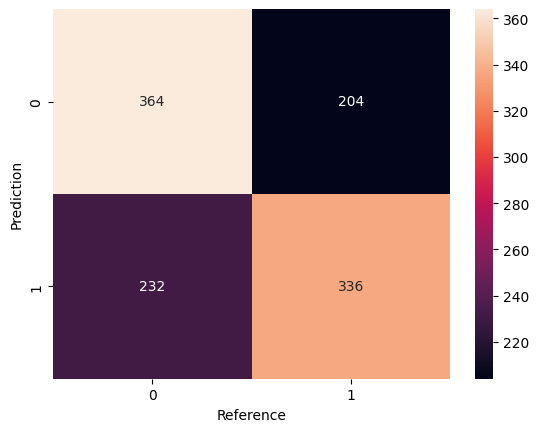

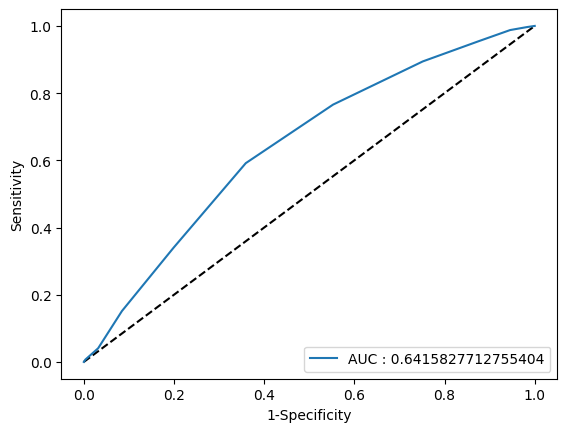

In [112]:
show_results(y_test, pred_knn)

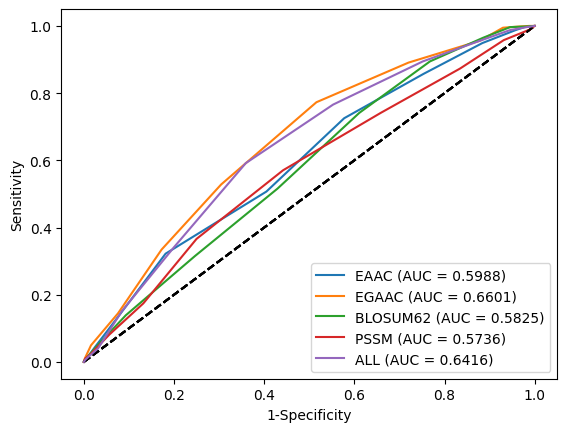

In [175]:
preds = [
    ['EAAC', pred_knn_eaac],
    ['EGAAC', pred_knn_egaac],
    ['BLOSUM62', pred_knn_blo],
    ['PSSM', pred_knn_pssm],
    ['ALL', pred_knn]
]

ROC_AUC_PLOT_ALL(y_test, preds)

### DNN

#### Feature Vector 1 : EAAC

In [126]:
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)

sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph())
K.set_session(sess)



dnn_eaac = Sequential([
    Dense(512, activation = 'relu', input_dim=eaac_train.shape[1]),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation = 'relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation = 'relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(64, activation = 'relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation = 'relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(256, activation = 'relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(2, activation = 'softmax')
])

dnn_eaac.compile(loss = tf.keras.losses.sparse_categorical_crossentropy, optimizer = 'Adam', metrics =['accuracy'])

dnn_eaac.fit(eaac_train, y_train, epochs=50)

pred_dnn_eaac = dnn_eaac.predict(eaac_test)

Epoch 1/50
264/264 [==============================] - 4s 8ms/step - loss: 0.9799 - accuracy: 0.4936
Epoch 2/50
264/264 [==============================] - 2s 8ms/step - loss: 0.7511 - accuracy: 0.5014
Epoch 3/50
264/264 [==============================] - 2s 8ms/step - loss: 0.7113 - accuracy: 0.5021
Epoch 4/50
264/264 [==============================] - 2s 8ms/step - loss: 0.7039 - accuracy: 0.5191
Epoch 5/50
264/264 [==============================] - 2s 8ms/step - loss: 0.6944 - accuracy: 0.5418
Epoch 6/50
264/264 [==============================] - 2s 8ms/step - loss: 0.6836 - accuracy: 0.5742
Epoch 7/50
264/264 [==============================] - 2s 8ms/step - loss: 0.6660 - accuracy: 0.5938
Epoch 8/50
264/264 [==============================] - 2s 8ms/step - loss: 0.6545 - accuracy: 0.6187
Epoch 9/50
264/264 [==============================] - 3s 10ms/step - loss: 0.6463 - accuracy: 0.6299
Epoch 10/50
264/264 [==============================] - 2s 8ms/step - loss: 0.6279 - accuracy: 0.649

              precision    recall  f1-score   support

         0.0       0.74      0.53      0.62       568
         1.0       0.64      0.82      0.71       568

    accuracy                           0.67      1136
   macro avg       0.69      0.67      0.67      1136
weighted avg       0.69      0.67      0.67      1136

MCC : 0.363697858108502
Kappa : 0.3485915492957746


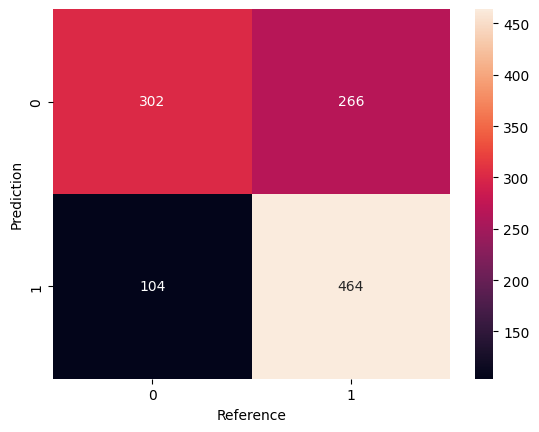

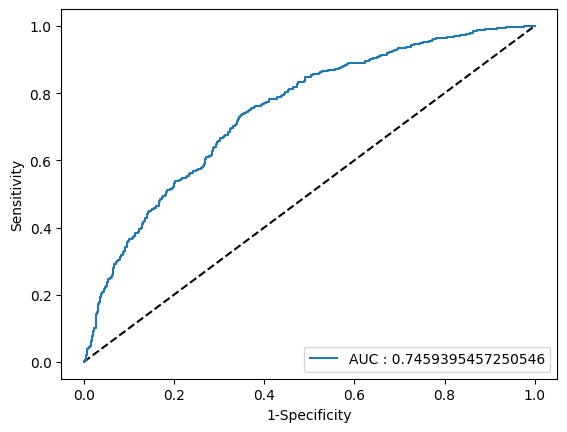

In [127]:
show_results(y_test, pred_dnn_eaac)

#### Feature Vector 2 : EGAAC

In [129]:
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)

sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph())
K.set_session(sess)



dnn_egaac = Sequential([
    Dense(512, activation = 'relu', input_dim=egaac_train.shape[1]),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation = 'relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation = 'relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(64, activation = 'relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation = 'relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(256, activation = 'relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(2, activation = 'softmax')
])

dnn_egaac.compile(loss = tf.keras.losses.sparse_categorical_crossentropy, optimizer = 'Adam', metrics =['accuracy'])

dnn_egaac.fit(egaac_train, y_train, epochs=50)

pred_dnn_egaac = dnn_egaac.predict(egaac_test)

Epoch 1/50
264/264 [==============================] - 4s 6ms/step - loss: 0.9484 - accuracy: 0.5235
Epoch 2/50
264/264 [==============================] - 2s 6ms/step - loss: 0.7497 - accuracy: 0.5195
Epoch 3/50
264/264 [==============================] - 2s 6ms/step - loss: 0.7020 - accuracy: 0.5299
Epoch 4/50
264/264 [==============================] - 2s 7ms/step - loss: 0.6887 - accuracy: 0.5583
Epoch 5/50
264/264 [==============================] - 2s 7ms/step - loss: 0.6785 - accuracy: 0.5776
Epoch 6/50
264/264 [==============================] - 2s 6ms/step - loss: 0.6670 - accuracy: 0.5990
Epoch 7/50
264/264 [==============================] - 2s 7ms/step - loss: 0.6558 - accuracy: 0.6102
Epoch 8/50
264/264 [==============================] - 2s 6ms/step - loss: 0.6501 - accuracy: 0.6161
Epoch 9/50
264/264 [==============================] - 2s 6ms/step - loss: 0.6376 - accuracy: 0.6388
Epoch 10/50
264/264 [==============================] - 2s 6ms/step - loss: 0.6358 - accuracy: 0.6457

              precision    recall  f1-score   support

         0.0       0.71      0.58      0.64       568
         1.0       0.64      0.76      0.70       568

    accuracy                           0.67      1136
   macro avg       0.67      0.67      0.67      1136
weighted avg       0.67      0.67      0.67      1136

MCC : 0.34361401492046245
Kappa : 0.3380281690140845


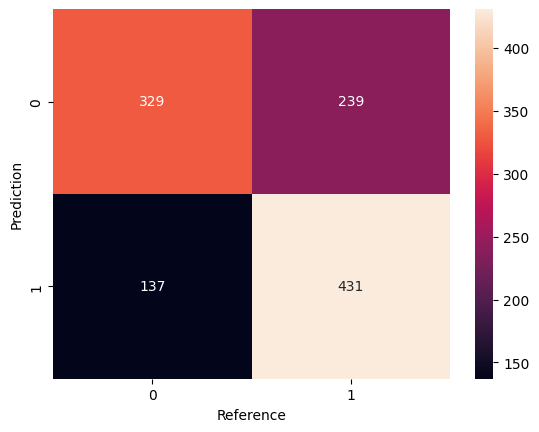

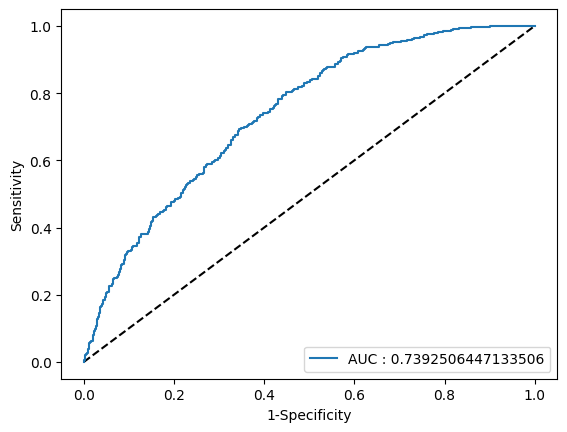

In [130]:
show_results(y_test, pred_dnn_egaac)

#### Feature Vector 3 : BLOSUM62

In [132]:
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)

sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph())
K.set_session(sess)



dnn_blo = Sequential([
    Dense(512, activation = 'relu', input_dim=blo_train.shape[1]),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation = 'relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation = 'relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(64, activation = 'relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation = 'relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(256, activation = 'relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(2, activation = 'softmax')
])

dnn_blo.compile(loss = tf.keras.losses.sparse_categorical_crossentropy, optimizer = 'Adam', metrics =['accuracy'])


dnn_blo.fit(blo_train, y_train, epochs=50)

pred_dnn_blo = dnn_blo.predict(blo_test)

Epoch 1/50
264/264 [==============================] - 4s 9ms/step - loss: 0.9631 - accuracy: 0.5091
Epoch 2/50
264/264 [==============================] - 2s 8ms/step - loss: 0.7576 - accuracy: 0.4906
Epoch 3/50
264/264 [==============================] - 2s 8ms/step - loss: 0.7119 - accuracy: 0.5005
Epoch 4/50
264/264 [==============================] - 2s 8ms/step - loss: 0.7055 - accuracy: 0.5101
Epoch 5/50
264/264 [==============================] - 2s 8ms/step - loss: 0.7079 - accuracy: 0.5076
Epoch 6/50
264/264 [==============================] - 2s 8ms/step - loss: 0.7036 - accuracy: 0.5129
Epoch 7/50
264/264 [==============================] - 2s 8ms/step - loss: 0.6964 - accuracy: 0.5385
Epoch 8/50
264/264 [==============================] - 2s 8ms/step - loss: 0.6956 - accuracy: 0.5359
Epoch 9/50
264/264 [==============================] - 2s 8ms/step - loss: 0.6914 - accuracy: 0.5435
Epoch 10/50
264/264 [==============================] - 2s 8ms/step - loss: 0.6850 - accuracy: 0.5616

              precision    recall  f1-score   support

         0.0       0.67      0.51      0.58       568
         1.0       0.61      0.74      0.67       568

    accuracy                           0.63      1136
   macro avg       0.64      0.63      0.62      1136
weighted avg       0.64      0.63      0.62      1136

MCC : 0.26597329183257856
Kappa : 0.2588028169014085


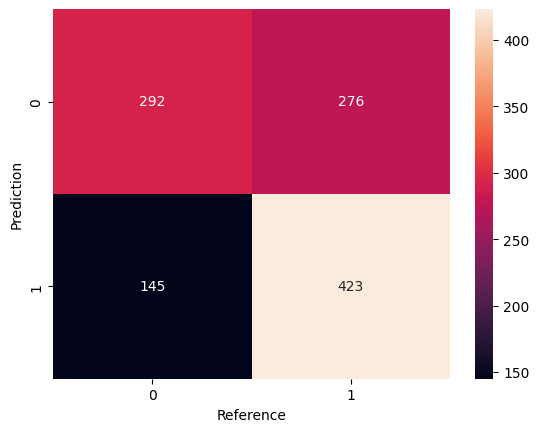

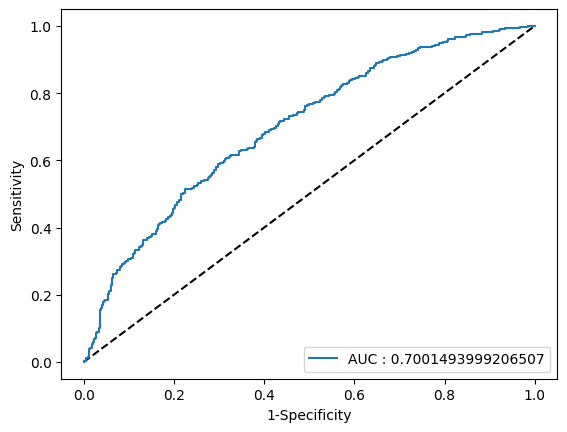

In [133]:
show_results(y_test, pred_dnn_blo)

#### Feature Vector 4 : PSSM

In [135]:
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)

sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph())
K.set_session(sess)



dnn_pssm = Sequential([
    Dense(512, activation = 'relu', input_dim=pssm_train.shape[1]),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation = 'relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation = 'relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(64, activation = 'relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation = 'relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(256, activation = 'relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(2, activation = 'softmax')
])

dnn_pssm.compile(loss = tf.keras.losses.sparse_categorical_crossentropy, optimizer = 'Adam', metrics =['accuracy'])


dnn_pssm.fit(pssm_train, y_train, epochs=50)

pred_dnn_pssm = dnn_pssm.predict(pssm_test)

Epoch 1/50
264/264 [==============================] - 4s 8ms/step - loss: 0.9787 - accuracy: 0.5060
Epoch 2/50
264/264 [==============================] - 2s 8ms/step - loss: 0.7489 - accuracy: 0.5076
Epoch 3/50
264/264 [==============================] - 2s 8ms/step - loss: 0.7047 - accuracy: 0.5321
Epoch 4/50
264/264 [==============================] - 2s 8ms/step - loss: 0.6935 - accuracy: 0.5411
Epoch 5/50
264/264 [==============================] - 2s 8ms/step - loss: 0.6892 - accuracy: 0.5518
Epoch 6/50
264/264 [==============================] - 2s 8ms/step - loss: 0.6842 - accuracy: 0.5602
Epoch 7/50
264/264 [==============================] - 2s 8ms/step - loss: 0.6818 - accuracy: 0.5598
Epoch 8/50
264/264 [==============================] - 2s 8ms/step - loss: 0.6701 - accuracy: 0.5900
Epoch 9/50
264/264 [==============================] - 2s 8ms/step - loss: 0.6608 - accuracy: 0.6007
Epoch 10/50
264/264 [==============================] - 2s 8ms/step - loss: 0.6559 - accuracy: 0.6164

              precision    recall  f1-score   support

         0.0       0.65      0.56      0.60       568
         1.0       0.61      0.70      0.65       568

    accuracy                           0.63      1136
   macro avg       0.63      0.63      0.63      1136
weighted avg       0.63      0.63      0.63      1136

MCC : 0.25950071379229345
Kappa : 0.25704225352112675


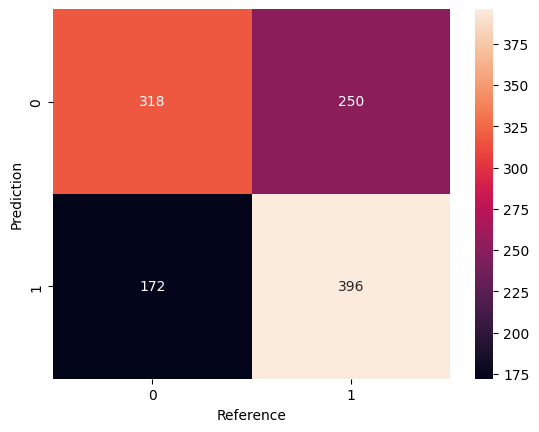

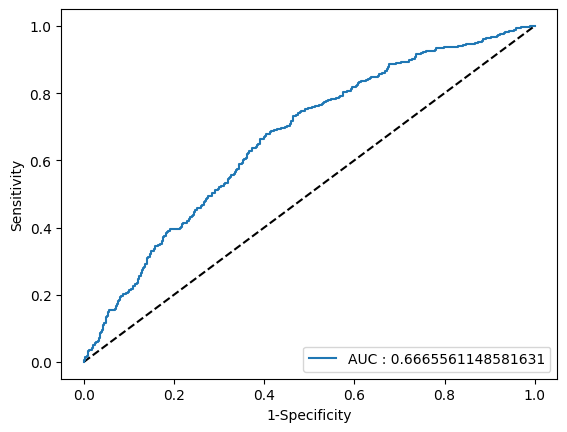

In [136]:
show_results(y_test, pred_dnn_pssm)

#### Feature Vector 5 : All

In [138]:
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)

sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph())
K.set_session(sess)



dnn_all = Sequential([
    Dense(512, activation = 'relu', input_dim=x_train.shape[1]),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation = 'relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation = 'relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(64, activation = 'relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation = 'relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(256, activation = 'relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(2, activation = 'softmax')
])

dnn_all.compile(loss = tf.keras.losses.sparse_categorical_crossentropy, optimizer = 'Adam', metrics =['accuracy'])


dnn_all.fit(x_train, y_train, epochs=50)

pred_dnn = dnn_all.predict(x_test)

Epoch 1/50
264/264 [==============================] - 5s 12ms/step - loss: 0.9604 - accuracy: 0.5095
Epoch 2/50
264/264 [==============================] - 3s 12ms/step - loss: 0.7530 - accuracy: 0.5113
Epoch 3/50
264/264 [==============================] - 3s 12ms/step - loss: 0.6979 - accuracy: 0.5384
Epoch 4/50
264/264 [==============================] - 3s 12ms/step - loss: 0.6809 - accuracy: 0.5637
Epoch 5/50
264/264 [==============================] - 3s 12ms/step - loss: 0.6728 - accuracy: 0.5743
Epoch 6/50
264/264 [==============================] - 3s 12ms/step - loss: 0.6519 - accuracy: 0.6155
Epoch 7/50
264/264 [==============================] - 3s 12ms/step - loss: 0.6246 - accuracy: 0.6526
Epoch 8/50
264/264 [==============================] - 3s 12ms/step - loss: 0.6037 - accuracy: 0.6771
Epoch 9/50
264/264 [==============================] - 3s 12ms/step - loss: 0.5723 - accuracy: 0.7021
Epoch 10/50
264/264 [==============================] - 3s 12ms/step - loss: 0.5434 - accura

              precision    recall  f1-score   support

         0.0       0.75      0.57      0.65       568
         1.0       0.65      0.81      0.72       568

    accuracy                           0.69      1136
   macro avg       0.70      0.69      0.68      1136
weighted avg       0.70      0.69      0.68      1136

MCC : 0.38968783564923737
Kappa : 0.3785211267605634


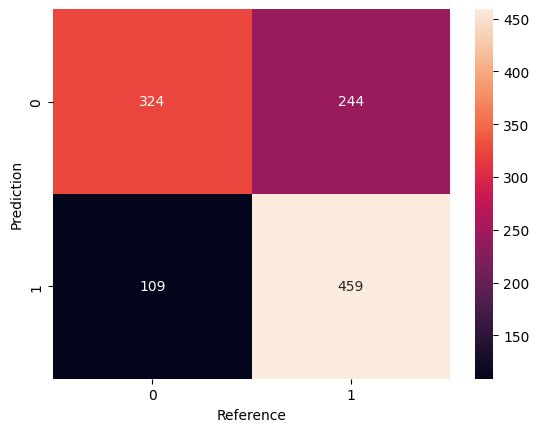

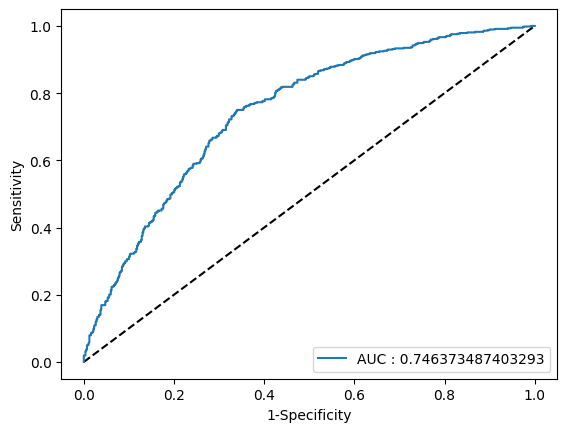

In [139]:
show_results(y_test, pred_dnn)

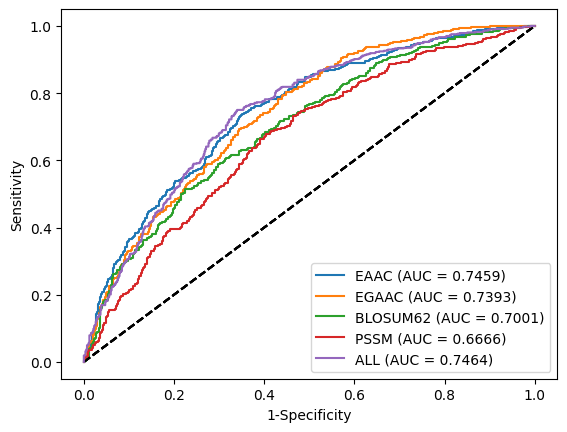

In [176]:
preds = [
    ['EAAC', pred_dnn_eaac],
    ['EGAAC', pred_dnn_egaac],
    ['BLOSUM62', pred_dnn_blo],
    ['PSSM', pred_dnn_pssm],
    ['ALL', pred_dnn]
]

ROC_AUC_PLOT_ALL(y_test, preds)

## II. CV

In [140]:
eaac = np.concatenate([eaac_train, eaac_test], axis=0)
egaac = np.concatenate([egaac_train, egaac_test], axis=0)
blo = np.concatenate([blo_train, blo_test], axis=0)
pssm = np.concatenate([pssm_train, pssm_test], axis=0)

x = np.concatenate([x_train, x_test], axis=0)
y = np.concatenate([y_train, y_test], axis=0)

### XGB

#### Feature Vector 1 : EAAC

In [148]:
K = 5

kf = KFold(n_splits=K, shuffle=True)

acc_avg = 0
mcc_avg = 0
kappa_avg = 0
sn_avg = 0
sp_avg = 0
f1_avg = 0
roc_avg = 0

for train_index, val_index in kf.split(eaac, y):
    data_train = eaac[train_index]
    label_train = y[train_index]
    data_val = eaac[val_index]
    label_val = y[val_index]

    xgb_cv = XGBClassifier(n_estimators=1000, max_depth=5, verbose=1, random_state=0)
    xgb_cv.fit(data_train, label_train)

    y_pred = xgb_cv.predict_proba(data_val)
    roc = roc_auc_score(label_val, y_pred[:, 1])
    y_pred = np.argmax(y_pred, axis=1)

    acc = accuracy_score(label_val, y_pred)
    mcc = matthews_corrcoef(label_val, y_pred)
    kappa = cohen_kappa_score(label_val, y_pred)
    r = recall_score(label_val, y_pred, average=None)
    sn = r[1]
    sp = r[0]
    f1 = f1_score(label_val, y_pred, average=None)[1]
    
    
    acc_avg += (acc / K)
    mcc_avg += (mcc / K)
    kappa_avg += (kappa / K)
    sn_avg += (sn / K)
    sp_avg += (sp / K)
    f1_avg += (f1 / K)
    roc_avg += (roc / K)

print(acc_avg, mcc_avg, kappa_avg, sn_avg, sp_avg, f1_avg, roc_avg)

[19:33:38] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[19:33:57] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[19:34:18] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[19:34:38] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[19:34:57] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

0.6675729462489

#### Feature Vector 1 : EGAAC

In [149]:
K = 5

kf = KFold(n_splits=K, shuffle=True)

acc_avg = 0
mcc_avg = 0
kappa_avg = 0
sn_avg = 0
sp_avg = 0
f1_avg = 0
roc_avg = 0

for train_index, val_index in kf.split(egaac, y):
    data_train = egaac[train_index]
    label_train = y[train_index]
    data_val = egaac[val_index]
    label_val = y[val_index]

    xgb_cv = XGBClassifier(n_estimators=1000, max_depth=5, verbose=1, random_state=0)
    xgb_cv.fit(data_train, label_train)

    y_pred = xgb_cv.predict_proba(data_val)
    roc = roc_auc_score(label_val, y_pred[:, 1])
    y_pred = np.argmax(y_pred, axis=1)

    acc = accuracy_score(label_val, y_pred)
    mcc = matthews_corrcoef(label_val, y_pred)
    kappa = cohen_kappa_score(label_val, y_pred)
    r = recall_score(label_val, y_pred, average=None)
    sn = r[1]
    sp = r[0]
    f1 = f1_score(label_val, y_pred, average=None)[1]
    
    
    acc_avg += (acc / K)
    mcc_avg += (mcc / K)
    kappa_avg += (kappa / K)
    sn_avg += (sn / K)
    sp_avg += (sp / K)
    f1_avg += (f1 / K)
    roc_avg += (roc / K)

print(acc_avg, mcc_avg, kappa_avg, sn_avg, sp_avg, f1_avg, roc_avg)

[19:35:54] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[19:36:00] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[19:36:06] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[19:36:12] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[19:36:18] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

0.6620380252593

#### Feature Vector 1 : BLOSUM62

In [150]:
K = 5

kf = KFold(n_splits=K, shuffle=True)

acc_avg = 0
mcc_avg = 0
kappa_avg = 0
sn_avg = 0
sp_avg = 0
f1_avg = 0
roc_avg = 0

for train_index, val_index in kf.split(blo, y):
    data_train = blo[train_index]
    label_train = y[train_index]
    data_val = blo[val_index]
    label_val = y[val_index]

    xgb_cv = XGBClassifier(n_estimators=1000, max_depth=5, verbose=1, random_state=0)
    xgb_cv.fit(data_train, label_train)

    y_pred = xgb_cv.predict_proba(data_val)
    roc = roc_auc_score(label_val, y_pred[:, 1])
    y_pred = np.argmax(y_pred, axis=1)

    acc = accuracy_score(label_val, y_pred)
    mcc = matthews_corrcoef(label_val, y_pred)
    kappa = cohen_kappa_score(label_val, y_pred)
    r = recall_score(label_val, y_pred, average=None)
    sn = r[1]
    sp = r[0]
    f1 = f1_score(label_val, y_pred, average=None)[1]
    
    
    acc_avg += (acc / K)
    mcc_avg += (mcc / K)
    kappa_avg += (kappa / K)
    sn_avg += (sn / K)
    sp_avg += (sp / K)
    f1_avg += (f1 / K)
    roc_avg += (roc / K)

print(acc_avg, mcc_avg, kappa_avg, sn_avg, sp_avg, f1_avg, roc_avg)

[19:36:56] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[19:37:20] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[19:37:43] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[19:38:06] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[19:38:27] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

0.6178749243691

#### Feature Vector 1 : PSSM

In [151]:
K = 5

kf = KFold(n_splits=K, shuffle=True)

acc_avg = 0
mcc_avg = 0
kappa_avg = 0
sn_avg = 0
sp_avg = 0
f1_avg = 0
roc_avg = 0

for train_index, val_index in kf.split(pssm, y):
    data_train = pssm[train_index]
    label_train = y[train_index]
    data_val = pssm[val_index]
    label_val = y[val_index]

    xgb_cv = XGBClassifier(n_estimators=1000, max_depth=5, verbose=1, random_state=0)
    xgb_cv.fit(data_train, label_train)

    y_pred = xgb_cv.predict_proba(data_val)
    roc = roc_auc_score(label_val, y_pred[:, 1])
    y_pred = np.argmax(y_pred, axis=1)

    acc = accuracy_score(label_val, y_pred)
    mcc = matthews_corrcoef(label_val, y_pred)
    kappa = cohen_kappa_score(label_val, y_pred)
    r = recall_score(label_val, y_pred, average=None)
    sn = r[1]
    sp = r[0]
    f1 = f1_score(label_val, y_pred, average=None)[1]
    
    
    acc_avg += (acc / K)
    mcc_avg += (mcc / K)
    kappa_avg += (kappa / K)
    sn_avg += (sn / K)
    sp_avg += (sp / K)
    f1_avg += (f1 / K)
    roc_avg += (roc / K)

print(acc_avg, mcc_avg, kappa_avg, sn_avg, sp_avg, f1_avg, roc_avg)

[19:38:55] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[19:39:21] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[19:39:43] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[19:40:05] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[19:40:26] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

0.6025252784031

#### Feature Vector 1 : All

In [152]:
K = 5

kf = KFold(n_splits=K, shuffle=True)

acc_avg = 0
mcc_avg = 0
kappa_avg = 0
sn_avg = 0
sp_avg = 0
f1_avg = 0
roc_avg = 0

for train_index, val_index in kf.split(x, y):
    data_train = x[train_index]
    label_train = y[train_index]
    data_val = x[val_index]
    label_val = y[val_index]

    xgb_cv = XGBClassifier(n_estimators=1000, max_depth=5, verbose=1, random_state=0)
    xgb_cv.fit(data_train, label_train)

    y_pred = xgb_cv.predict_proba(data_val)
    roc = roc_auc_score(label_val, y_pred[:, 1])
    y_pred = np.argmax(y_pred, axis=1)

    acc = accuracy_score(label_val, y_pred)
    mcc = matthews_corrcoef(label_val, y_pred)
    kappa = cohen_kappa_score(label_val, y_pred)
    r = recall_score(label_val, y_pred, average=None)
    sn = r[1]
    sp = r[0]
    f1 = f1_score(label_val, y_pred, average=None)[1]
    
    
    acc_avg += (acc / K)
    mcc_avg += (mcc / K)
    kappa_avg += (kappa / K)
    sn_avg += (sn / K)
    sp_avg += (sp / K)
    f1_avg += (f1 / K)
    roc_avg += (roc / K)

print(acc_avg, mcc_avg, kappa_avg, sn_avg, sp_avg, f1_avg, roc_avg)

[19:41:11] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[19:42:34] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[19:43:57] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[19:45:19] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[19:46:41] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

0.7000403909362

### RF

#### Feature Vector 1 : EAAC

In [153]:
K = 5

kf = KFold(n_splits=K, shuffle=True)

acc_avg = 0
mcc_avg = 0
kappa_avg = 0
sn_avg = 0
sp_avg = 0
f1_avg = 0
roc_avg = 0

for train_index, val_index in kf.split(eaac, y):
    data_train = eaac[train_index]
    label_train = y[train_index]
    data_val = eaac[val_index]
    label_val = y[val_index]

    rf_cv = RandomForestClassifier(max_depth=6, min_samples_split=10, n_estimators=1000, verbose=1, random_state=0)
    rf_cv.fit(data_train, label_train)

    y_pred = rf_cv.predict_proba(data_val)
    roc = roc_auc_score(label_val, y_pred[:, 1])
    y_pred = np.argmax(y_pred, axis=1)

    acc = accuracy_score(label_val, y_pred)
    mcc = matthews_corrcoef(label_val, y_pred)
    kappa = cohen_kappa_score(label_val, y_pred)
    r = recall_score(label_val, y_pred, average=None)
    sn = r[1]
    sp = r[0]
    f1 = f1_score(label_val, y_pred, average=None)[1]
    
    
    acc_avg += (acc / K)
    mcc_avg += (mcc / K)
    kappa_avg += (kappa / K)
    sn_avg += (sn / K)
    sp_avg += (sp / K)
    f1_avg += (f1 / K)
    roc_avg += (roc / K)

print(acc_avg, mcc_avg, kappa_avg, sn_avg, sp_avg, f1_avg, roc_avg)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   11.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   11.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   11.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[

0.6315510446589665 0.2654670931198627 0.2640834710923225 0.653715405180191 0.6107988517393202 0.6388305216960581 0.6876071935168788


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished


#### Feature Vector 1 : EGAAC

In [154]:
K = 5

kf = KFold(n_splits=K, shuffle=True)

acc_avg = 0
mcc_avg = 0
kappa_avg = 0
sn_avg = 0
sp_avg = 0
f1_avg = 0
roc_avg = 0

for train_index, val_index in kf.split(egaac, y):
    data_train = egaac[train_index]
    label_train = y[train_index]
    data_val = egaac[val_index]
    label_val = y[val_index]

    rf_cv = RandomForestClassifier(max_depth=6, min_samples_split=10, n_estimators=1000, verbose=1, random_state=0)
    rf_cv.fit(data_train, label_train)

    y_pred = rf_cv.predict_proba(data_val)
    roc = roc_auc_score(label_val, y_pred[:, 1])
    y_pred = np.argmax(y_pred, axis=1)

    acc = accuracy_score(label_val, y_pred)
    mcc = matthews_corrcoef(label_val, y_pred)
    kappa = cohen_kappa_score(label_val, y_pred)
    r = recall_score(label_val, y_pred, average=None)
    sn = r[1]
    sp = r[0]
    f1 = f1_score(label_val, y_pred, average=None)[1]
    
    
    acc_avg += (acc / K)
    mcc_avg += (mcc / K)
    kappa_avg += (kappa / K)
    sn_avg += (sn / K)
    sp_avg += (sp / K)
    f1_avg += (f1 / K)
    roc_avg += (roc / K)

print(acc_avg, mcc_avg, kappa_avg, sn_avg, sp_avg, f1_avg, roc_avg)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    7.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    7.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    6.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[

0.667780460816431 0.3390802496879508 0.3356313952231796 0.7381891465774884 0.5974898851283 0.6896129053657375 0.7301094385414066


#### Feature Vector 1 : BLOSUM62

In [155]:
K = 5

kf = KFold(n_splits=K, shuffle=True)

acc_avg = 0
mcc_avg = 0
kappa_avg = 0
sn_avg = 0
sp_avg = 0
f1_avg = 0
roc_avg = 0

for train_index, val_index in kf.split(blo, y):
    data_train = blo[train_index]
    label_train = y[train_index]
    data_val = blo[val_index]
    label_val = y[val_index]

    rf_cv = RandomForestClassifier(max_depth=6, min_samples_split=10, n_estimators=1000, verbose=1, random_state=0)
    rf_cv.fit(data_train, label_train)

    y_pred = rf_cv.predict_proba(data_val)
    roc = roc_auc_score(label_val, y_pred[:, 1])
    y_pred = np.argmax(y_pred, axis=1)

    acc = accuracy_score(label_val, y_pred)
    mcc = matthews_corrcoef(label_val, y_pred)
    kappa = cohen_kappa_score(label_val, y_pred)
    r = recall_score(label_val, y_pred, average=None)
    sn = r[1]
    sp = r[0]
    f1 = f1_score(label_val, y_pred, average=None)[1]
    
    
    acc_avg += (acc / K)
    mcc_avg += (mcc / K)
    kappa_avg += (kappa / K)
    sn_avg += (sn / K)
    sp_avg += (sp / K)
    f1_avg += (f1 / K)
    roc_avg += (roc / K)

print(acc_avg, mcc_avg, kappa_avg, sn_avg, sp_avg, f1_avg, roc_avg)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   19.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   18.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   18.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[

0.5759042718457187 0.1575292935089712 0.15448583979074337 0.6518310365577544 0.5032739543498032 0.6050259944669489 0.6268384869109214


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished


#### Feature Vector 1 : PSSM

In [156]:
K = 5

kf = KFold(n_splits=K, shuffle=True)

acc_avg = 0
mcc_avg = 0
kappa_avg = 0
sn_avg = 0
sp_avg = 0
f1_avg = 0
roc_avg = 0

for train_index, val_index in kf.split(pssm, y):
    data_train = pssm[train_index]
    label_train = y[train_index]
    data_val = pssm[val_index]
    label_val = y[val_index]

    rf_cv = RandomForestClassifier(max_depth=6, min_samples_split=10, n_estimators=1000, verbose=1, random_state=0)
    rf_cv.fit(data_train, label_train)

    y_pred = rf_cv.predict_proba(data_val)
    roc = roc_auc_score(label_val, y_pred[:, 1])
    y_pred = np.argmax(y_pred, axis=1)

    acc = accuracy_score(label_val, y_pred)
    mcc = matthews_corrcoef(label_val, y_pred)
    kappa = cohen_kappa_score(label_val, y_pred)
    r = recall_score(label_val, y_pred, average=None)
    sn = r[1]
    sp = r[0]
    f1 = f1_score(label_val, y_pred, average=None)[1]
    
    
    acc_avg += (acc / K)
    mcc_avg += (mcc / K)
    kappa_avg += (kappa / K)
    sn_avg += (sn / K)
    sp_avg += (sp / K)
    f1_avg += (f1 / K)
    roc_avg += (roc / K)

print(acc_avg, mcc_avg, kappa_avg, sn_avg, sp_avg, f1_avg, roc_avg)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   22.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   22.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   22.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[

0.5854060624560524 0.17308826664392182 0.17113486326227043 0.6567225253289097 0.5144910505005152 0.6128919716907326 0.622253626476055


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished


#### Feature Vector 1 : All

In [157]:
K = 5

kf = KFold(n_splits=K, shuffle=True)

acc_avg = 0
mcc_avg = 0
kappa_avg = 0
sn_avg = 0
sp_avg = 0
f1_avg = 0
roc_avg = 0

for train_index, val_index in kf.split(x, y):
    data_train = x[train_index]
    label_train = y[train_index]
    data_val = x[val_index]
    label_val = y[val_index]

    rf_cv = RandomForestClassifier(max_depth=6, min_samples_split=10, n_estimators=1000, verbose=1, random_state=0)
    rf_cv.fit(data_train, label_train)

    y_pred = rf_cv.predict_proba(data_val)
    roc = roc_auc_score(label_val, y_pred[:, 1])
    y_pred = np.argmax(y_pred, axis=1)

    acc = accuracy_score(label_val, y_pred)
    mcc = matthews_corrcoef(label_val, y_pred)
    kappa = cohen_kappa_score(label_val, y_pred)
    r = recall_score(label_val, y_pred, average=None)
    sn = r[1]
    sp = r[0]
    f1 = f1_score(label_val, y_pred, average=None)[1]
    
    
    acc_avg += (acc / K)
    mcc_avg += (mcc / K)
    kappa_avg += (kappa / K)
    sn_avg += (sn / K)
    sp_avg += (sp / K)
    f1_avg += (f1 / K)
    roc_avg += (roc / K)

print(acc_avg, mcc_avg, kappa_avg, sn_avg, sp_avg, f1_avg, roc_avg)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   32.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   32.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   31.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[

0.6434533977989393 0.28893248809345673 0.2871140164509795 0.6947037866539871 0.5925652993902275 0.6606558118869106 0.7001825917966646


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished


### KNN

#### Feature Vector 1 : EAAC

In [158]:
K = 5

kf = KFold(n_splits=K, shuffle=True)

acc_avg = 0
mcc_avg = 0
kappa_avg = 0
sn_avg = 0
sp_avg = 0
f1_avg = 0
roc_avg = 0

for train_index, val_index in kf.split(eaac, y):
    data_train = eaac[train_index]
    label_train = y[train_index]
    data_val = eaac[val_index]
    label_val = y[val_index]

    knn_cv = KNeighborsClassifier(leaf_size=1, n_neighbors=11)
    knn_cv.fit(data_train, label_train)

    y_pred = knn_cv.predict_proba(data_val)
    roc = roc_auc_score(label_val, y_pred[:, 1])
    y_pred = np.argmax(y_pred, axis=1)

    acc = accuracy_score(label_val, y_pred)
    mcc = matthews_corrcoef(label_val, y_pred)
    kappa = cohen_kappa_score(label_val, y_pred)
    r = recall_score(label_val, y_pred, average=None)
    sn = r[1]
    sp = r[0]
    f1 = f1_score(label_val, y_pred, average=None)[1]
    
    
    acc_avg += (acc / K)
    mcc_avg += (mcc / K)
    kappa_avg += (kappa / K)
    sn_avg += (sn / K)
    sp_avg += (sp / K)
    f1_avg += (f1 / K)
    roc_avg += (roc / K)

print(acc_avg, mcc_avg, kappa_avg, sn_avg, sp_avg, f1_avg, roc_avg)

0.5641046130700927 0.131999508165132 0.12810996668330174 0.684969176375513 0.44319718049472795 0.6111256538114208 0.5896222530421507


#### Feature Vector 1 : EGAAC

In [159]:
K = 5

kf = KFold(n_splits=K, shuffle=True)

acc_avg = 0
mcc_avg = 0
kappa_avg = 0
sn_avg = 0
sp_avg = 0
f1_avg = 0
roc_avg = 0

for train_index, val_index in kf.split(egaac, y):
    data_train = egaac[train_index]
    label_train = y[train_index]
    data_val = egaac[val_index]
    label_val = y[val_index]

    knn_cv = KNeighborsClassifier(leaf_size=1, n_neighbors=11)
    knn_cv.fit(data_train, label_train)

    y_pred = knn_cv.predict_proba(data_val)
    roc = roc_auc_score(label_val, y_pred[:, 1])
    y_pred = np.argmax(y_pred, axis=1)

    acc = accuracy_score(label_val, y_pred)
    mcc = matthews_corrcoef(label_val, y_pred)
    kappa = cohen_kappa_score(label_val, y_pred)
    r = recall_score(label_val, y_pred, average=None)
    sn = r[1]
    sp = r[0]
    f1 = f1_score(label_val, y_pred, average=None)[1]
    
    
    acc_avg += (acc / K)
    mcc_avg += (mcc / K)
    kappa_avg += (kappa / K)
    sn_avg += (sn / K)
    sp_avg += (sp / K)
    f1_avg += (f1 / K)
    roc_avg += (roc / K)

print(acc_avg, mcc_avg, kappa_avg, sn_avg, sp_avg, f1_avg, roc_avg)

0.585406607542912 0.1764480905445687 0.17087937354430366 0.7107216058518251 0.46019350040190665 0.6315267327226473 0.6167478322283643


#### Feature Vector 1 : BLOSUM62

In [160]:
K = 5

kf = KFold(n_splits=K, shuffle=True)

acc_avg = 0
mcc_avg = 0
kappa_avg = 0
sn_avg = 0
sp_avg = 0
f1_avg = 0
roc_avg = 0

for train_index, val_index in kf.split(blo, y):
    data_train = blo[train_index]
    label_train = y[train_index]
    data_val = blo[val_index]
    label_val = y[val_index]

    knn_cv = KNeighborsClassifier(leaf_size=1, n_neighbors=11)
    knn_cv.fit(data_train, label_train)

    y_pred = knn_cv.predict_proba(data_val)
    roc = roc_auc_score(label_val, y_pred[:, 1])
    y_pred = np.argmax(y_pred, axis=1)

    acc = accuracy_score(label_val, y_pred)
    mcc = matthews_corrcoef(label_val, y_pred)
    kappa = cohen_kappa_score(label_val, y_pred)
    r = recall_score(label_val, y_pred, average=None)
    sn = r[1]
    sp = r[0]
    f1 = f1_score(label_val, y_pred, average=None)[1]
    
    
    acc_avg += (acc / K)
    mcc_avg += (mcc / K)
    kappa_avg += (kappa / K)
    sn_avg += (sn / K)
    sp_avg += (sp / K)
    f1_avg += (f1 / K)
    roc_avg += (roc / K)

print(acc_avg, mcc_avg, kappa_avg, sn_avg, sp_avg, f1_avg, roc_avg)

0.547712433976354 0.09632044745279149 0.09563207420677465 0.49141707180864413 0.6043193655275677 0.5205598276579837 0.5769717383655811


#### Feature Vector 1 : PSSM

In [161]:
K = 5

kf = KFold(n_splits=K, shuffle=True)

acc_avg = 0
mcc_avg = 0
kappa_avg = 0
sn_avg = 0
sp_avg = 0
f1_avg = 0
roc_avg = 0

for train_index, val_index in kf.split(pssm, y):
    data_train = pssm[train_index]
    label_train = y[train_index]
    data_val = pssm[val_index]
    label_val = y[val_index]

    knn_cv = KNeighborsClassifier(leaf_size=1, n_neighbors=11)
    knn_cv.fit(data_train, label_train)

    y_pred = knn_cv.predict_proba(data_val)
    roc = roc_auc_score(label_val, y_pred[:, 1])
    y_pred = np.argmax(y_pred, axis=1)

    acc = accuracy_score(label_val, y_pred)
    mcc = matthews_corrcoef(label_val, y_pred)
    kappa = cohen_kappa_score(label_val, y_pred)
    r = recall_score(label_val, y_pred, average=None)
    sn = r[1]
    sp = r[0]
    f1 = f1_score(label_val, y_pred, average=None)[1]
    
    
    acc_avg += (acc / K)
    mcc_avg += (mcc / K)
    kappa_avg += (kappa / K)
    sn_avg += (sn / K)
    sp_avg += (sp / K)
    f1_avg += (f1 / K)
    roc_avg += (roc / K)

print(acc_avg, mcc_avg, kappa_avg, sn_avg, sp_avg, f1_avg, roc_avg)

0.5371670745733332 0.09003772995124834 0.0746346842949081 0.2624368604735832 0.8122976358194883 0.36082916810430493 0.5744681329835047


#### Feature Vector 1 : All

In [162]:
K = 5

kf = KFold(n_splits=K, shuffle=True)

acc_avg = 0
mcc_avg = 0
kappa_avg = 0
sn_avg = 0
sp_avg = 0
f1_avg = 0
roc_avg = 0

for train_index, val_index in kf.split(x, y):
    data_train = x[train_index]
    label_train = y[train_index]
    data_val = x[val_index]
    label_val = y[val_index]

    knn_cv = KNeighborsClassifier(leaf_size=1, n_neighbors=11)
    knn_cv.fit(data_train, label_train)

    y_pred = knn_cv.predict_proba(data_val)
    roc = roc_auc_score(label_val, y_pred[:, 1])
    y_pred = np.argmax(y_pred, axis=1)

    acc = accuracy_score(label_val, y_pred)
    mcc = matthews_corrcoef(label_val, y_pred)
    kappa = cohen_kappa_score(label_val, y_pred)
    r = recall_score(label_val, y_pred, average=None)
    sn = r[1]
    sp = r[0]
    f1 = f1_score(label_val, y_pred, average=None)[1]
    
    
    acc_avg += (acc / K)
    mcc_avg += (mcc / K)
    kappa_avg += (kappa / K)
    sn_avg += (sn / K)
    sp_avg += (sp / K)
    f1_avg += (f1 / K)
    roc_avg += (roc / K)

print(acc_avg, mcc_avg, kappa_avg, sn_avg, sp_avg, f1_avg, roc_avg)

0.5720416228325984 0.14682831466269738 0.1444079421436255 0.4857439201431906 0.6587826468890872 0.5314794805964266 0.6128696585760798


### DNN

#### Feature Vector 1 : EAAC

In [165]:
K = 5

kf = KFold(n_splits=K, shuffle=True)

acc_avg = 0
mcc_avg = 0
kappa_avg = 0
sn_avg = 0
sp_avg = 0
f1_avg = 0
roc_avg = 0

for train_index, val_index in kf.split(eaac, y):
    data_train = eaac[train_index]
    label_train = y[train_index]
    data_val = eaac[val_index]
    label_val = y[val_index]


    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(0)
    random.seed(0)
    tf.random.set_seed(0)

    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph())
    backend.set_session(sess)



    dnn_cv = Sequential([
        Dense(512, activation = 'relu', input_dim=data_train.shape[1]),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation = 'relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(128, activation = 'relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64, activation = 'relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(128, activation = 'relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(256, activation = 'relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(2, activation = 'softmax')
    ])

    dnn_cv.compile(loss = tf.keras.losses.sparse_categorical_crossentropy, optimizer = 'Adam', metrics =['accuracy'])

    dnn_cv.fit(data_train, label_train, epochs=50)

    y_pred = dnn_cv.predict(data_val)
    roc = roc_auc_score(label_val, y_pred[:, 1])
    y_pred = np.argmax(y_pred, axis=1)

    acc = accuracy_score(label_val, y_pred)
    mcc = matthews_corrcoef(label_val, y_pred)
    kappa = cohen_kappa_score(label_val, y_pred)
    r = recall_score(label_val, y_pred, average=None)
    sn = r[1]
    sp = r[0]
    f1 = f1_score(label_val, y_pred, average=None)[1]
    
    
    acc_avg += (acc / K)
    mcc_avg += (mcc / K)
    kappa_avg += (kappa / K)
    sn_avg += (sn / K)
    sp_avg += (sp / K)
    f1_avg += (f1 / K)
    roc_avg += (roc / K)

print(acc_avg, mcc_avg, kappa_avg, sn_avg, sp_avg, f1_avg, roc_avg)

Epoch 1/50
240/240 [==============================] - 4s 9ms/step - loss: 0.9993 - accuracy: 0.4963
Epoch 2/50
240/240 [==============================] - 2s 9ms/step - loss: 0.7636 - accuracy: 0.5013
Epoch 3/50
240/240 [==============================] - 2s 9ms/step - loss: 0.7126 - accuracy: 0.5097
Epoch 4/50
240/240 [==============================] - 2s 9ms/step - loss: 0.7039 - accuracy: 0.5153
Epoch 5/50
240/240 [==============================] - 2s 9ms/step - loss: 0.7023 - accuracy: 0.5131
Epoch 6/50
240/240 [==============================] - 2s 9ms/step - loss: 0.6938 - accuracy: 0.5505
Epoch 7/50
240/240 [==============================] - 2s 9ms/step - loss: 0.6863 - accuracy: 0.5656
Epoch 8/50
240/240 [==============================] - 2s 9ms/step - loss: 0.6743 - accuracy: 0.5876
Epoch 9/50
240/240 [==============================] - 2s 9ms/step - loss: 0.6557 - accuracy: 0.6146
Epoch 10/50
240/240 [==============================] - 2s 9ms/step - loss: 0.6499 - accuracy: 0.6286

#### Feature Vector 1 : EGAAC

In [166]:
K = 5

kf = KFold(n_splits=K, shuffle=True)

acc_avg = 0
mcc_avg = 0
kappa_avg = 0
sn_avg = 0
sp_avg = 0
f1_avg = 0
roc_avg = 0

for train_index, val_index in kf.split(egaac, y):
    data_train = egaac[train_index]
    label_train = y[train_index]
    data_val = egaac[val_index]
    label_val = y[val_index]

    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(0)
    random.seed(0)
    tf.random.set_seed(0)

    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph())
    backend.set_session(sess)



    dnn_cv = Sequential([
        Dense(512, activation = 'relu', input_dim=data_train.shape[1]),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation = 'relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(128, activation = 'relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64, activation = 'relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(128, activation = 'relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(256, activation = 'relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(2, activation = 'softmax')
    ])

    dnn_cv.compile(loss = tf.keras.losses.sparse_categorical_crossentropy, optimizer = 'Adam', metrics =['accuracy'])

    dnn_cv.fit(data_train, label_train, epochs=50)

    y_pred = dnn_cv.predict(data_val)
    roc = roc_auc_score(label_val, y_pred[:, 1])
    y_pred = np.argmax(y_pred, axis=1)

    acc = accuracy_score(label_val, y_pred)
    mcc = matthews_corrcoef(label_val, y_pred)
    kappa = cohen_kappa_score(label_val, y_pred)
    r = recall_score(label_val, y_pred, average=None)
    sn = r[1]
    sp = r[0]
    f1 = f1_score(label_val, y_pred, average=None)[1]
    
    
    acc_avg += (acc / K)
    mcc_avg += (mcc / K)
    kappa_avg += (kappa / K)
    sn_avg += (sn / K)
    sp_avg += (sp / K)
    f1_avg += (f1 / K)
    roc_avg += (roc / K)

print(acc_avg, mcc_avg, kappa_avg, sn_avg, sp_avg, f1_avg, roc_avg)

Epoch 1/50
240/240 [==============================] - 3s 6ms/step - loss: 0.9900 - accuracy: 0.5021
Epoch 2/50
240/240 [==============================] - 2s 6ms/step - loss: 0.7598 - accuracy: 0.5068
Epoch 3/50
240/240 [==============================] - 2s 6ms/step - loss: 0.7056 - accuracy: 0.5241
Epoch 4/50
240/240 [==============================] - 2s 7ms/step - loss: 0.6905 - accuracy: 0.5560
Epoch 5/50
240/240 [==============================] - 2s 6ms/step - loss: 0.6826 - accuracy: 0.5737
Epoch 6/50
240/240 [==============================] - 2s 7ms/step - loss: 0.6743 - accuracy: 0.5894
Epoch 7/50
240/240 [==============================] - 2s 6ms/step - loss: 0.6607 - accuracy: 0.6074
Epoch 8/50
240/240 [==============================] - 2s 6ms/step - loss: 0.6564 - accuracy: 0.6058
Epoch 9/50
240/240 [==============================] - 2s 6ms/step - loss: 0.6501 - accuracy: 0.6179
Epoch 10/50
240/240 [==============================] - 2s 6ms/step - loss: 0.6381 - accuracy: 0.6406

#### Feature Vector 1 : BLOSUM62

In [168]:
K = 5

kf = KFold(n_splits=K, shuffle=True)

acc_avg = 0
mcc_avg = 0
kappa_avg = 0
sn_avg = 0
sp_avg = 0
f1_avg = 0
roc_avg = 0

for train_index, val_index in kf.split(blo, y):
    data_train = blo[train_index]
    label_train = y[train_index]
    data_val = blo[val_index]
    label_val = y[val_index]

    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(0)
    random.seed(0)
    tf.random.set_seed(0)

    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph())
    backend.set_session(sess)



    dnn_cv = Sequential([
        Dense(512, activation = 'relu', input_dim=data_train.shape[1]),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation = 'relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(128, activation = 'relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64, activation = 'relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(128, activation = 'relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(256, activation = 'relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(2, activation = 'softmax')
    ])

    dnn_cv.compile(loss = tf.keras.losses.sparse_categorical_crossentropy, optimizer = 'Adam', metrics =['accuracy'])

    dnn_cv.fit(data_train, label_train, epochs=50)

    y_pred = dnn_cv.predict(data_val)
    roc = roc_auc_score(label_val, y_pred[:, 1])
    y_pred = np.argmax(y_pred, axis=1)

    acc = accuracy_score(label_val, y_pred)
    mcc = matthews_corrcoef(label_val, y_pred)
    kappa = cohen_kappa_score(label_val, y_pred)
    r = recall_score(label_val, y_pred, average=None)
    sn = r[1]
    sp = r[0]
    f1 = f1_score(label_val, y_pred, average=None)[1]
    
    
    acc_avg += (acc / K)
    mcc_avg += (mcc / K)
    kappa_avg += (kappa / K)
    sn_avg += (sn / K)
    sp_avg += (sp / K)
    f1_avg += (f1 / K)
    roc_avg += (roc / K)

print(acc_avg, mcc_avg, kappa_avg, sn_avg, sp_avg, f1_avg, roc_avg)

Epoch 1/50
240/240 [==============================] - 4s 8ms/step - loss: 0.9678 - accuracy: 0.5095
Epoch 2/50
240/240 [==============================] - 2s 8ms/step - loss: 0.7709 - accuracy: 0.4931
Epoch 3/50
240/240 [==============================] - 2s 8ms/step - loss: 0.7159 - accuracy: 0.5026
Epoch 4/50
240/240 [==============================] - 2s 8ms/step - loss: 0.7070 - accuracy: 0.5017
Epoch 5/50
240/240 [==============================] - 2s 8ms/step - loss: 0.7070 - accuracy: 0.5070
Epoch 6/50
240/240 [==============================] - 2s 8ms/step - loss: 0.7084 - accuracy: 0.5005
Epoch 7/50
240/240 [==============================] - 2s 8ms/step - loss: 0.7015 - accuracy: 0.5179
Epoch 8/50
240/240 [==============================] - 2s 8ms/step - loss: 0.6943 - accuracy: 0.5359
Epoch 9/50
240/240 [==============================] - 2s 8ms/step - loss: 0.6895 - accuracy: 0.5493
Epoch 10/50
240/240 [==============================] - 2s 8ms/step - loss: 0.6818 - accuracy: 0.5594

#### Feature Vector 1 : PSSM

In [169]:
K = 5

kf = KFold(n_splits=K, shuffle=True)

acc_avg = 0
mcc_avg = 0
kappa_avg = 0
sn_avg = 0
sp_avg = 0
f1_avg = 0
roc_avg = 0

for train_index, val_index in kf.split(pssm, y):
    data_train = pssm[train_index]
    label_train = y[train_index]
    data_val = pssm[val_index]
    label_val = y[val_index]

    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(0)
    random.seed(0)
    tf.random.set_seed(0)

    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph())
    backend.set_session(sess)



    dnn_cv = Sequential([
        Dense(512, activation = 'relu', input_dim=data_train.shape[1]),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation = 'relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(128, activation = 'relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64, activation = 'relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(128, activation = 'relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(256, activation = 'relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(2, activation = 'softmax')
    ])

    dnn_cv.compile(loss = tf.keras.losses.sparse_categorical_crossentropy, optimizer = 'Adam', metrics =['accuracy'])

    dnn_cv.fit(data_train, label_train, epochs=50)

    y_pred = dnn_cv.predict(data_val)
    roc = roc_auc_score(label_val, y_pred[:, 1])
    y_pred = np.argmax(y_pred, axis=1)

    acc = accuracy_score(label_val, y_pred)
    mcc = matthews_corrcoef(label_val, y_pred)
    kappa = cohen_kappa_score(label_val, y_pred)
    r = recall_score(label_val, y_pred, average=None)
    sn = r[1]
    sp = r[0]
    f1 = f1_score(label_val, y_pred, average=None)[1]
    
    
    acc_avg += (acc / K)
    mcc_avg += (mcc / K)
    kappa_avg += (kappa / K)
    sn_avg += (sn / K)
    sp_avg += (sp / K)
    f1_avg += (f1 / K)
    roc_avg += (roc / K)

print(acc_avg, mcc_avg, kappa_avg, sn_avg, sp_avg, f1_avg, roc_avg)

Epoch 1/50
240/240 [==============================] - 4s 9ms/step - loss: 0.9633 - accuracy: 0.5151
Epoch 2/50
240/240 [==============================] - 2s 8ms/step - loss: 0.7632 - accuracy: 0.5171
Epoch 3/50
240/240 [==============================] - 2s 8ms/step - loss: 0.7044 - accuracy: 0.5301
Epoch 4/50
240/240 [==============================] - 2s 8ms/step - loss: 0.6902 - accuracy: 0.5546
Epoch 5/50
240/240 [==============================] - 2s 8ms/step - loss: 0.6903 - accuracy: 0.5436
Epoch 6/50
240/240 [==============================] - 2s 8ms/step - loss: 0.6870 - accuracy: 0.5508
Epoch 7/50
240/240 [==============================] - 2s 8ms/step - loss: 0.6802 - accuracy: 0.5638
Epoch 8/50
240/240 [==============================] - 2s 8ms/step - loss: 0.6810 - accuracy: 0.5720
Epoch 9/50
240/240 [==============================] - 2s 8ms/step - loss: 0.6721 - accuracy: 0.5847
Epoch 10/50
240/240 [==============================] - 2s 8ms/step - loss: 0.6588 - accuracy: 0.6055

#### Feature Vector 1 : All

In [170]:
K = 5

kf = KFold(n_splits=K, shuffle=True)

acc_avg = 0
mcc_avg = 0
kappa_avg = 0
sn_avg = 0
sp_avg = 0
f1_avg = 0
roc_avg = 0

for train_index, val_index in kf.split(x, y):
    data_train = x[train_index]
    label_train = y[train_index]
    data_val = x[val_index]
    label_val = y[val_index]

    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(0)
    random.seed(0)
    tf.random.set_seed(0)

    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph())
    backend.set_session(sess)



    dnn_cv = Sequential([
        Dense(512, activation = 'relu', input_dim=data_train.shape[1]),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation = 'relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(128, activation = 'relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64, activation = 'relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(128, activation = 'relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(256, activation = 'relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(2, activation = 'softmax')
    ])

    dnn_cv.compile(loss = tf.keras.losses.sparse_categorical_crossentropy, optimizer = 'Adam', metrics =['accuracy'])

    dnn_cv.fit(data_train, label_train, epochs=50)

    y_pred = dnn_cv.predict(data_val)
    roc = roc_auc_score(label_val, y_pred[:, 1])
    y_pred = np.argmax(y_pred, axis=1)

    acc = accuracy_score(label_val, y_pred)
    mcc = matthews_corrcoef(label_val, y_pred)
    kappa = cohen_kappa_score(label_val, y_pred)
    r = recall_score(label_val, y_pred, average=None)
    sn = r[1]
    sp = r[0]
    f1 = f1_score(label_val, y_pred, average=None)[1]
    
    
    acc_avg += (acc / K)
    mcc_avg += (mcc / K)
    kappa_avg += (kappa / K)
    sn_avg += (sn / K)
    sp_avg += (sp / K)
    f1_avg += (f1 / K)
    roc_avg += (roc / K)

print(acc_avg, mcc_avg, kappa_avg, sn_avg, sp_avg, f1_avg, roc_avg)

Epoch 1/50
240/240 [==============================] - 5s 14ms/step - loss: 0.9824 - accuracy: 0.5012
Epoch 2/50
240/240 [==============================] - 3s 14ms/step - loss: 0.7530 - accuracy: 0.5215
Epoch 3/50
240/240 [==============================] - 3s 14ms/step - loss: 0.7013 - accuracy: 0.5385
Epoch 4/50
240/240 [==============================] - 3s 14ms/step - loss: 0.6901 - accuracy: 0.5428
Epoch 5/50
240/240 [==============================] - 3s 14ms/step - loss: 0.6720 - accuracy: 0.5820
Epoch 6/50
240/240 [==============================] - 3s 14ms/step - loss: 0.6615 - accuracy: 0.6002
Epoch 7/50
240/240 [==============================] - 3s 14ms/step - loss: 0.6450 - accuracy: 0.6308
Epoch 8/50
240/240 [==============================] - 3s 14ms/step - loss: 0.6232 - accuracy: 0.6560
Epoch 9/50
240/240 [==============================] - 3s 14ms/step - loss: 0.5875 - accuracy: 0.6954
Epoch 10/50
240/240 [==============================] - 3s 15ms/step - loss: 0.5650 - accura

### SVM

#### Feature Vector 1 : EAAC

In [318]:
K = 5

kf = KFold(n_splits=K, shuffle=True)

acc_avg = 0
mcc_avg = 0
kappa_avg = 0
sn_avg = 0
sp_avg = 0
f1_avg = 0
roc_avg = 0

for train_index, val_index in kf.split(eaac, y):
    data_train = eaac[train_index]
    label_train = y[train_index]
    data_val = eaac[val_index]
    label_val = y[val_index]

    svm_cv = SVC(C=10, gamma=0.001, kernel='rbf', verbose=1, probability=True, random_state=0)
    svm_cv.fit(data_train, label_train)

    y_pred = svm_cv.predict_proba(data_val)
    roc = roc_auc_score(label_val, y_pred[:, 1])
    y_pred = np.argmax(y_pred, axis=1)

    acc = accuracy_score(label_val, y_pred)
    mcc = matthews_corrcoef(label_val, y_pred)
    kappa = cohen_kappa_score(label_val, y_pred)
    r = recall_score(label_val, y_pred, average=None)
    sn = r[1]
    sp = r[0]
    f1 = f1_score(label_val, y_pred, average=None)[1]
    
    
    acc_avg += (acc / K)
    mcc_avg += (mcc / K)
    kappa_avg += (kappa / K)
    sn_avg += (sn / K)
    sp_avg += (sp / K)
    f1_avg += (f1 / K)
    roc_avg += (roc / K)

print(acc_avg, mcc_avg, kappa_avg, sn_avg, sp_avg, f1_avg, roc_avg)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]0.6288383653935254 0.2579851185618986 0.2577621818311245 0.6281099211290353 0.6297936713665477 0.6284987181344814 0.6832806000834257


#### Feature Vector 1 : EGAAC

In [319]:
K = 5

kf = KFold(n_splits=K, shuffle=True)

acc_avg = 0
mcc_avg = 0
kappa_avg = 0
sn_avg = 0
sp_avg = 0
f1_avg = 0
roc_avg = 0

for train_index, val_index in kf.split(egaac, y):
    data_train = egaac[train_index]
    label_train = y[train_index]
    data_val = egaac[val_index]
    label_val = y[val_index]

    svm_cv = SVC(C=10, gamma=0.001, kernel='rbf', verbose=1, probability=True, random_state=0)
    svm_cv.fit(data_train, label_train)

    y_pred = svm_cv.predict_proba(data_val)
    roc = roc_auc_score(label_val, y_pred[:, 1])
    y_pred = np.argmax(y_pred, axis=1)

    acc = accuracy_score(label_val, y_pred)
    mcc = matthews_corrcoef(label_val, y_pred)
    kappa = cohen_kappa_score(label_val, y_pred)
    r = recall_score(label_val, y_pred, average=None)
    sn = r[1]
    sp = r[0]
    f1 = f1_score(label_val, y_pred, average=None)[1]
    
    
    acc_avg += (acc / K)
    mcc_avg += (mcc / K)
    kappa_avg += (kappa / K)
    sn_avg += (sn / K)
    sp_avg += (sp / K)
    f1_avg += (f1 / K)
    roc_avg += (roc / K)

print(acc_avg, mcc_avg, kappa_avg, sn_avg, sp_avg, f1_avg, roc_avg)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]0.6520140959461891 0.3046879828505286 0.30402842222701515 0.6803141512347852 0.6238383268361345 0.6614259060014072 0.7123783789803126


#### Feature Vector 1 : BLOSUM62

In [320]:
K = 5

kf = KFold(n_splits=K, shuffle=True)

acc_avg = 0
mcc_avg = 0
kappa_avg = 0
sn_avg = 0
sp_avg = 0
f1_avg = 0
roc_avg = 0

for train_index, val_index in kf.split(blo, y):
    data_train = blo[train_index]
    label_train = y[train_index]
    data_val = blo[val_index]
    label_val = y[val_index]

    svm_cv = SVC(C=10, gamma=0.001, kernel='rbf', verbose=1, probability=True, random_state=0)
    svm_cv.fit(data_train, label_train)

    y_pred = svm_cv.predict_proba(data_val)
    roc = roc_auc_score(label_val, y_pred[:, 1])
    y_pred = np.argmax(y_pred, axis=1)

    acc = accuracy_score(label_val, y_pred)
    mcc = matthews_corrcoef(label_val, y_pred)
    kappa = cohen_kappa_score(label_val, y_pred)
    r = recall_score(label_val, y_pred, average=None)
    sn = r[1]
    sp = r[0]
    f1 = f1_score(label_val, y_pred, average=None)[1]
    
    
    acc_avg += (acc / K)
    mcc_avg += (mcc / K)
    kappa_avg += (kappa / K)
    sn_avg += (sn / K)
    sp_avg += (sp / K)
    f1_avg += (f1 / K)
    roc_avg += (roc / K)

print(acc_avg, mcc_avg, kappa_avg, sn_avg, sp_avg, f1_avg, roc_avg)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]0.6074329134347558 0.21492862168191407 0.21481372190965747 0.5944314073420693 0.6204211141611307 0.602169171993984 0.6563322555422795


#### Feature Vector 1 : PSSM

In [321]:
K = 5

kf = KFold(n_splits=K, shuffle=True)

acc_avg = 0
mcc_avg = 0
kappa_avg = 0
sn_avg = 0
sp_avg = 0
f1_avg = 0
roc_avg = 0

for train_index, val_index in kf.split(pssm, y):
    data_train = pssm[train_index]
    label_train = y[train_index]
    data_val = pssm[val_index]
    label_val = y[val_index]

    svm_cv = SVC(C=10, gamma=0.001, kernel='rbf', verbose=1, probability=True, random_state=0)
    svm_cv.fit(data_train, label_train)

    y_pred = svm_cv.predict_proba(data_val)
    roc = roc_auc_score(label_val, y_pred[:, 1])
    y_pred = np.argmax(y_pred, axis=1)

    acc = accuracy_score(label_val, y_pred)
    mcc = matthews_corrcoef(label_val, y_pred)
    kappa = cohen_kappa_score(label_val, y_pred)
    r = recall_score(label_val, y_pred, average=None)
    sn = r[1]
    sp = r[0]
    f1 = f1_score(label_val, y_pred, average=None)[1]
    
    
    acc_avg += (acc / K)
    mcc_avg += (mcc / K)
    kappa_avg += (kappa / K)
    sn_avg += (sn / K)
    sp_avg += (sp / K)
    f1_avg += (f1 / K)
    roc_avg += (roc / K)

print(acc_avg, mcc_avg, kappa_avg, sn_avg, sp_avg, f1_avg, roc_avg)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]0.6029457584066021 0.20687268929667557 0.20647484300357438 0.605391077492965 0.6014047762670395 0.6037520850067474 0.646631741209233


#### Feature Vector 1 : All

In [322]:
K = 5

kf = KFold(n_splits=K, shuffle=True)

acc_avg = 0
mcc_avg = 0
kappa_avg = 0
sn_avg = 0
sp_avg = 0
f1_avg = 0
roc_avg = 0

for train_index, val_index in kf.split(x, y):
    data_train = x[train_index]
    label_train = y[train_index]
    data_val = x[val_index]
    label_val = y[val_index]

    svm_cv = SVC(C=10, gamma=0.001, kernel='rbf', verbose=1, probability=True, random_state=0)
    svm_cv.fit(data_train, label_train)

    y_pred = svm_cv.predict_proba(data_val)
    roc = roc_auc_score(label_val, y_pred[:, 1])
    y_pred = np.argmax(y_pred, axis=1)

    acc = accuracy_score(label_val, y_pred)
    mcc = matthews_corrcoef(label_val, y_pred)
    kappa = cohen_kappa_score(label_val, y_pred)
    r = recall_score(label_val, y_pred, average=None)
    sn = r[1]
    sp = r[0]
    f1 = f1_score(label_val, y_pred, average=None)[1]
    
    
    acc_avg += (acc / K)
    mcc_avg += (mcc / K)
    kappa_avg += (kappa / K)
    sn_avg += (sn / K)
    sp_avg += (sp / K)
    f1_avg += (f1 / K)
    roc_avg += (roc / K)

print(acc_avg, mcc_avg, kappa_avg, sn_avg, sp_avg, f1_avg, roc_avg)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]0.6554622609112764 0.3123532040835607 0.31123743569227696 0.6909426231871789 0.6207946277221226 0.6671127021994694 0.724265638628665


# 3) Hybrid Model

## I. Independent Test

In [196]:
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)

sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph())
backend.set_session(sess)

lstm = Sequential(
    [
        Embedding(MAX_NB_WORDS, 5, input_length=WINDOW_SIZE),
        LSTM(units=32),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(2, activation='softmax')
    ]
)

lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [197]:
lstm.fit(np.array(token_train), y_train, validation_data=(np.array(token_test), y_test), epochs=300, batch_size=512)

Epoch 1/300
17/17 [==============================] - 3s 71ms/step - loss: 0.6932 - accuracy: 0.5046 - val_loss: 0.6930 - val_accuracy: 0.4991
Epoch 2/300
17/17 [==============================] - 1s 48ms/step - loss: 0.6931 - accuracy: 0.4974 - val_loss: 0.6927 - val_accuracy: 0.5643
Epoch 3/300
17/17 [==============================] - 1s 45ms/step - loss: 0.6925 - accuracy: 0.5333 - val_loss: 0.6907 - val_accuracy: 0.5467
Epoch 4/300
17/17 [==============================] - 1s 45ms/step - loss: 0.6871 - accuracy: 0.5396 - val_loss: 0.6779 - val_accuracy: 0.5651
Epoch 5/300
17/17 [==============================] - 1s 45ms/step - loss: 0.6746 - accuracy: 0.5819 - val_loss: 0.6734 - val_accuracy: 0.5731
Epoch 6/300
17/17 [==============================] - 1s 45ms/step - loss: 0.6693 - accuracy: 0.5886 - val_loss: 0.6766 - val_accuracy: 0.5590
Epoch 7/300
17/17 [==============================] - 1s 48ms/step - loss: 0.6672 - accuracy: 0.5944 - val_loss: 0.6698 - val_accuracy: 0.5836
Epoch 

In [198]:
pred_lstm = lstm.predict(np.array(token_test))

36/36 [==============================] - 0s 5ms/step


              precision    recall  f1-score   support

         0.0       0.80      0.62      0.70       568
         1.0       0.69      0.85      0.76       568

    accuracy                           0.74      1136
   macro avg       0.75      0.74      0.73      1136
weighted avg       0.75      0.74      0.73      1136

MCC : 0.4858929334455408
Kappa : 0.4735915492957746


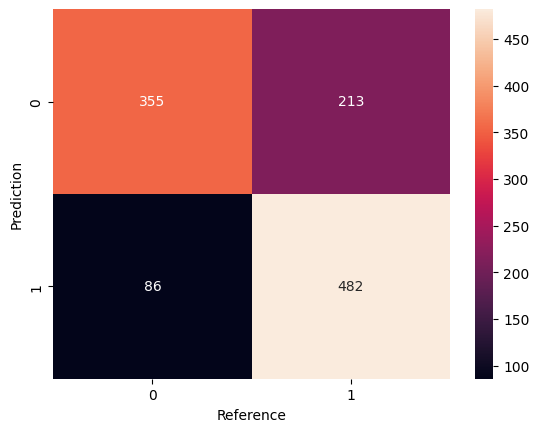

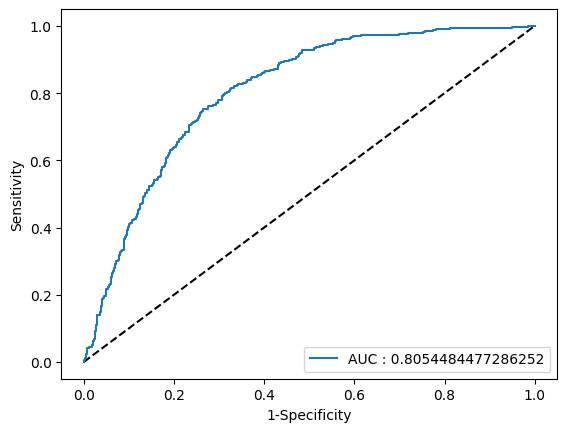

In [199]:
show_results(y_test, pred_lstm)

In [202]:
pred_hybrid = np.mean([pred_xgb, pred_rf, pred_svm, pred_lstm], axis=0)

              precision    recall  f1-score   support

         0.0       0.79      0.63      0.71       568
         1.0       0.70      0.84      0.76       568

    accuracy                           0.74      1136
   macro avg       0.75      0.74      0.73      1136
weighted avg       0.75      0.74      0.73      1136

MCC : 0.480011683799895
Kappa : 0.47007042253521125


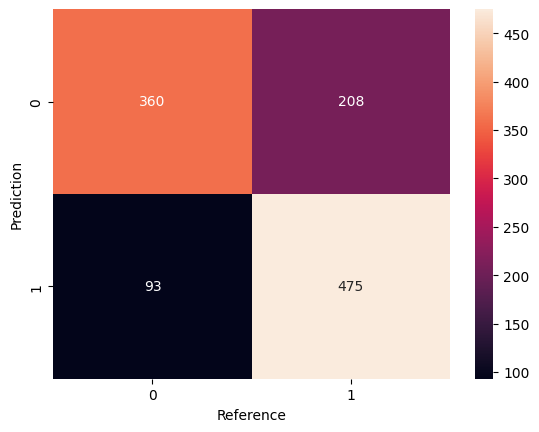

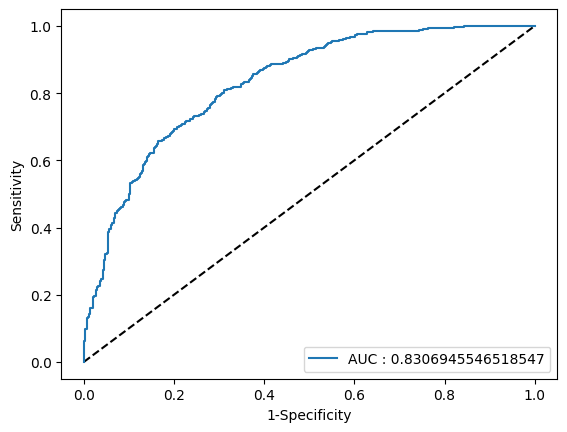

In [203]:
show_results(y_test, pred_hybrid)

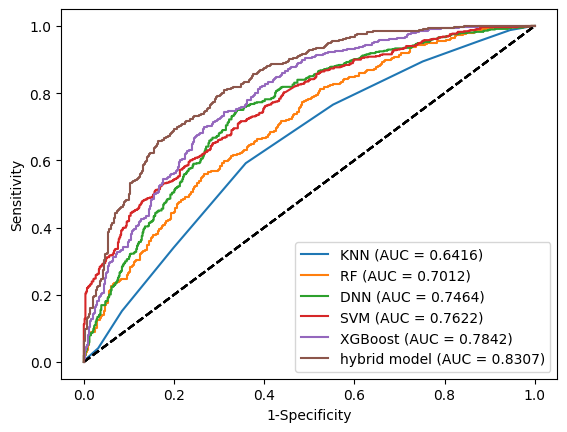

In [326]:
preds = [
    ['KNN', pred_knn],
    ['RF', pred_rf],
    ['DNN', pred_dnn],
    ['SVM', pred_svm],
    ['XGBoost', pred_xgb],
    ['hybrid model', pred_hybrid]
]

ROC_AUC_PLOT_ALL(y_test, preds)

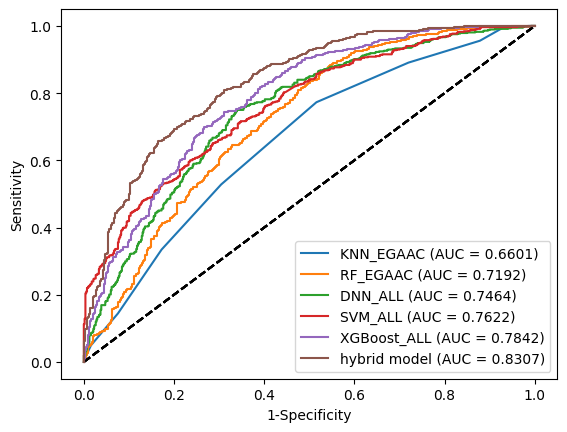

In [327]:
preds = [
    ['KNN_EGAAC', pred_knn_egaac],
    ['RF_EGAAC', pred_rf_egaac],
    ['DNN_ALL', pred_dnn],
    ['SVM_ALL', pred_svm],
    ['XGBoost_ALL', pred_xgb],
    ['hybrid model', pred_hybrid]
]

ROC_AUC_PLOT_ALL(y_test, preds)

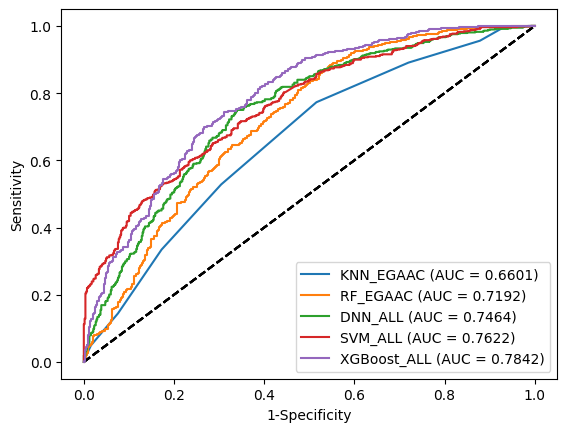

In [328]:
preds = [
    ['KNN_EGAAC', pred_knn_egaac],
    ['RF_EGAAC', pred_rf_egaac],
    ['DNN_ALL', pred_dnn],
    ['SVM_ALL', pred_svm],
    ['XGBoost_ALL', pred_xgb]
]

ROC_AUC_PLOT_ALL(y_test, preds)

## II. CV

In [206]:
token = np.concatenate([token_train, token_test], axis=0)

In [207]:
K = 5

kf = KFold(n_splits=K, shuffle=True)

acc_avg = 0
mcc_avg = 0
kappa_avg = 0
sn_avg = 0
sp_avg = 0
f1_avg = 0
roc_avg = 0

for train_index, val_index in kf.split(x, y):
    data_train = x[train_index]
    label_train = y[train_index]
    data_val = x[val_index]
    label_val = y[val_index]

    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(0)
    random.seed(0)
    tf.random.set_seed(0)

    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph())
    backend.set_session(sess)

    lstm_cv = Sequential(
        [
            Embedding(MAX_NB_WORDS, 5, input_length=WINDOW_SIZE),
            LSTM(units=32),
            Dropout(0.2),
            Dense(128, activation='relu'),
            Dropout(0.2),
            Dense(2, activation='softmax')
        ]
    )
    print('lstm')
    lstm_cv.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    lstm_cv.fit(np.array(token[train_index]), label_train, validation_data=(np.array(token[val_index]), label_val), epochs=300, batch_size=512)

    print('XGB')
    xgb_cv = XGBClassifier(n_estimators=1000, max_depth=5, verbose=1, random_state=0)
    xgb_cv.fit(data_train, label_train)

    print('RF')
    rf_cv = RandomForestClassifier(max_depth=6, min_samples_split=10, n_estimators=1000, verbose=1, random_state=0)
    rf_cv.fit(data_train, label_train)

    print('SVM')
    svm_cv = SVC(C=10, gamma=0.001, kernel='rbf', verbose=1, probability=True, random_state=0)
    svm_cv.fit(data_train, label_train)

    y_lstm = lstm_cv.predict(np.array(token[val_index]))
    y_xgb = xgb_cv.predict_proba(data_val)
    y_rf = rf_cv.predict_proba(data_val)
    y_svm = svm_cv.predict_proba(data_val)

    y_pred = np.mean([y_lstm, y_xgb, y_rf, y_svm], axis=0)

    roc = roc_auc_score(label_val, y_pred[:, 1])
    y_pred = np.argmax(y_pred, axis=1)

    acc = accuracy_score(label_val, y_pred)
    mcc = matthews_corrcoef(label_val, y_pred)
    kappa = cohen_kappa_score(label_val, y_pred)
    r = recall_score(label_val, y_pred, average=None)
    sn = r[1]
    sp = r[0]
    f1 = f1_score(label_val, y_pred, average=None)[1]
    
    
    acc_avg += (acc / K)
    mcc_avg += (mcc / K)
    kappa_avg += (kappa / K)
    sn_avg += (sn / K)
    sp_avg += (sp / K)
    f1_avg += (f1 / K)
    roc_avg += (roc / K)

print(acc_avg, mcc_avg, kappa_avg, sn_avg, sp_avg, f1_avg, roc_avg)

lstm
Epoch 1/300
15/15 [==============================] - 3s 97ms/step - loss: 0.6932 - accuracy: 0.4986 - val_loss: 0.6935 - val_accuracy: 0.4833
Epoch 2/300
15/15 [==============================] - 1s 51ms/step - loss: 0.6930 - accuracy: 0.5061 - val_loss: 0.6932 - val_accuracy: 0.4849
Epoch 3/300
15/15 [==============================] - 1s 49ms/step - loss: 0.6923 - accuracy: 0.5211 - val_loss: 0.6926 - val_accuracy: 0.4922
Epoch 4/300
15/15 [==============================] - 1s 48ms/step - loss: 0.6852 - accuracy: 0.5505 - val_loss: 0.6759 - val_accuracy: 0.5825
Epoch 5/300
15/15 [==============================] - 1s 49ms/step - loss: 0.6765 - accuracy: 0.5730 - val_loss: 0.6735 - val_accuracy: 0.5846
Epoch 6/300
15/15 [==============================] - 1s 54ms/step - loss: 0.6713 - accuracy: 0.5859 - val_loss: 0.6744 - val_accuracy: 0.5632
Epoch 7/300
15/15 [==============================] - 1s 48ms/step - loss: 0.6677 - accuracy: 0.5912 - val_loss: 0.6680 - val_accuracy: 0.5939
E

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   31.7s finished


SVM
60/60 [==============================] - 1s 4ms/step


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished


lstm
Epoch 1/300
15/15 [==============================] - 3s 81ms/step - loss: 0.6932 - accuracy: 0.5007 - val_loss: 0.6932 - val_accuracy: 0.4896
Epoch 2/300
15/15 [==============================] - 1s 47ms/step - loss: 0.6930 - accuracy: 0.5069 - val_loss: 0.6931 - val_accuracy: 0.5031
Epoch 3/300
15/15 [==============================] - 1s 52ms/step - loss: 0.6925 - accuracy: 0.5248 - val_loss: 0.6918 - val_accuracy: 0.5428
Epoch 4/300
15/15 [==============================] - 1s 47ms/step - loss: 0.6868 - accuracy: 0.5623 - val_loss: 0.6822 - val_accuracy: 0.5605
Epoch 5/300
15/15 [==============================] - 1s 47ms/step - loss: 0.6736 - accuracy: 0.5816 - val_loss: 0.6730 - val_accuracy: 0.5699
Epoch 6/300
15/15 [==============================] - 1s 47ms/step - loss: 0.6719 - accuracy: 0.5864 - val_loss: 0.6745 - val_accuracy: 0.5720
Epoch 7/300
15/15 [==============================] - 1s 47ms/step - loss: 0.6658 - accuracy: 0.5925 - val_loss: 0.6714 - val_accuracy: 0.5835
E

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   32.4s finished


SVM
60/60 [==============================] - 1s 4ms/step


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished


lstm
Epoch 1/300
15/15 [==============================] - 3s 78ms/step - loss: 0.6932 - accuracy: 0.4924 - val_loss: 0.6931 - val_accuracy: 0.4943
Epoch 2/300
15/15 [==============================] - 1s 50ms/step - loss: 0.6930 - accuracy: 0.5091 - val_loss: 0.6926 - val_accuracy: 0.5339
Epoch 3/300
15/15 [==============================] - 1s 49ms/step - loss: 0.6908 - accuracy: 0.5483 - val_loss: 0.6870 - val_accuracy: 0.5689
Epoch 4/300
15/15 [==============================] - 1s 55ms/step - loss: 0.6784 - accuracy: 0.5660 - val_loss: 0.6767 - val_accuracy: 0.5736
Epoch 5/300
15/15 [==============================] - 1s 53ms/step - loss: 0.6742 - accuracy: 0.5765 - val_loss: 0.6770 - val_accuracy: 0.5689
Epoch 6/300
15/15 [==============================] - 1s 53ms/step - loss: 0.6722 - accuracy: 0.5796 - val_loss: 0.6730 - val_accuracy: 0.5851
Epoch 7/300
15/15 [==============================] - 1s 53ms/step - loss: 0.6666 - accuracy: 0.5857 - val_loss: 0.6725 - val_accuracy: 0.5955
E

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   31.8s finished


SVM
60/60 [==============================] - 1s 10ms/step


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished


lstm
Epoch 1/300
15/15 [==============================] - 3s 78ms/step - loss: 0.6933 - accuracy: 0.4956 - val_loss: 0.6931 - val_accuracy: 0.4977
Epoch 2/300
15/15 [==============================] - 1s 48ms/step - loss: 0.6930 - accuracy: 0.5027 - val_loss: 0.6927 - val_accuracy: 0.5060
Epoch 3/300
15/15 [==============================] - 1s 49ms/step - loss: 0.6926 - accuracy: 0.5191 - val_loss: 0.6918 - val_accuracy: 0.5102
Epoch 4/300
15/15 [==============================] - 1s 48ms/step - loss: 0.6883 - accuracy: 0.5413 - val_loss: 0.6787 - val_accuracy: 0.5650
Epoch 5/300
15/15 [==============================] - 1s 55ms/step - loss: 0.6781 - accuracy: 0.5666 - val_loss: 0.6721 - val_accuracy: 0.5833
Epoch 6/300
15/15 [==============================] - 1s 49ms/step - loss: 0.6736 - accuracy: 0.5768 - val_loss: 0.6660 - val_accuracy: 0.5963
Epoch 7/300
15/15 [==============================] - 1s 49ms/step - loss: 0.6723 - accuracy: 0.5773 - val_loss: 0.6680 - val_accuracy: 0.5943
E

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   31.5s finished


SVM
60/60 [==============================] - 1s 4ms/step


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished


lstm
Epoch 1/300
15/15 [==============================] - 5s 92ms/step - loss: 0.6933 - accuracy: 0.4877 - val_loss: 0.6929 - val_accuracy: 0.5243
Epoch 2/300
15/15 [==============================] - 1s 61ms/step - loss: 0.6930 - accuracy: 0.5142 - val_loss: 0.6935 - val_accuracy: 0.4841
Epoch 3/300
15/15 [==============================] - 1s 62ms/step - loss: 0.6927 - accuracy: 0.5117 - val_loss: 0.6919 - val_accuracy: 0.5478
Epoch 4/300
15/15 [==============================] - 1s 62ms/step - loss: 0.6899 - accuracy: 0.5474 - val_loss: 0.6797 - val_accuracy: 0.5749
Epoch 5/300
15/15 [==============================] - 1s 62ms/step - loss: 0.6780 - accuracy: 0.5714 - val_loss: 0.6685 - val_accuracy: 0.5880
Epoch 6/300
15/15 [==============================] - 1s 62ms/step - loss: 0.6727 - accuracy: 0.5805 - val_loss: 0.6619 - val_accuracy: 0.5948
Epoch 7/300
15/15 [==============================] - 1s 62ms/step - loss: 0.6690 - accuracy: 0.5885 - val_loss: 0.6618 - val_accuracy: 0.5948
E

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   31.7s finished


SVM
60/60 [==============================] - 1s 4ms/step


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished


0.7278148012885854 0.45715891886546406 0.4555791064435923 0.7650213507941053 0.6907344635891568 0.7374433470043265 0.8072524177260529


# 4) Other Tools

### LEMP

In [211]:
pred_lemp = np.mean([pred_lstm, pred_rf_eaac], axis=0)

              precision    recall  f1-score   support

         0.0       0.81      0.63      0.71       568
         1.0       0.70      0.85      0.77       568

    accuracy                           0.74      1136
   macro avg       0.75      0.74      0.74      1136
weighted avg       0.75      0.74      0.74      1136

MCC : 0.4959223309723474
Kappa : 0.48415492957746475


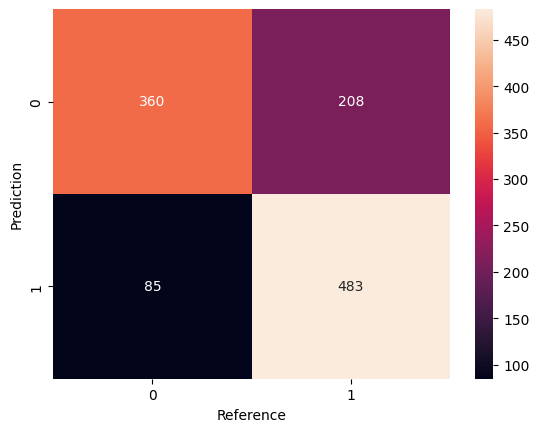

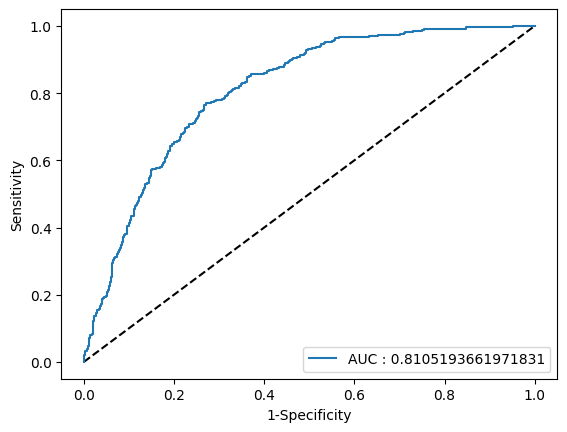

In [212]:
show_results(y_test, pred_lemp)

### Mal-light

In [213]:
P_train = pssm_train.reshape(pssm_train.shape[0], 35, 20)
P_test = pssm_test.reshape(pssm_test.shape[0], 35, 20)

mean_train = np.mean(P_train, axis=1)
mean_test = np.mean(P_test, axis=1)

SD_train = np.sqrt(np.mean(np.power(P_train - mean_train[:, None], 2), axis=1))
SD_test = np.sqrt(np.mean(np.power(P_test - mean_test[:, None], 2), axis=1))

E_train = (P_train - mean_train[:, None]) / SD_train[:, None]
E_test = (P_test - mean_test[:, None]) / SD_test[:, None]

P_train = E_train.transpose((0, 2, 1)) @ E_train
P_test = E_test.transpose((0, 2, 1)) @ E_test


index = np.tril_indices(20)

x_train_mallight = []
for p in P_train:
    x_train_mallight.append(p[index])

x_test_mallight = []
for p in P_test:
    x_test_mallight.append(p[index])

x_train_mallight = np.array(x_train_mallight)
x_test_mallight = np.array(x_test_mallight)

In [214]:
lightgbm = LGBMClassifier(num_leaves=31, n_estimators=40, learning_rate=0.1, random_state=0)

In [215]:
lightgbm.fit(x_train_mallight, y_train)

[LightGBM] [Info] Number of positive: 4221, number of negative: 4221
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008773 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 8442, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(n_estimators=40, random_state=0)

In [216]:
pred_mallight = lightgbm.predict_proba(x_test_mallight)

              precision    recall  f1-score   support

         0.0       0.63      0.50      0.56       568
         1.0       0.59      0.70      0.64       568

    accuracy                           0.60      1136
   macro avg       0.61      0.60      0.60      1136
weighted avg       0.61      0.60      0.60      1136

MCC : 0.21018736584349343
Kappa : 0.20598591549295775


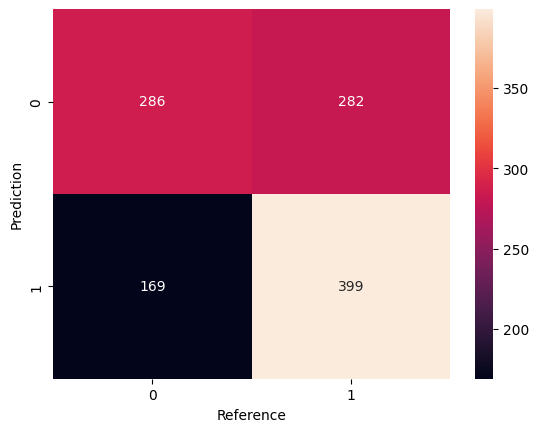

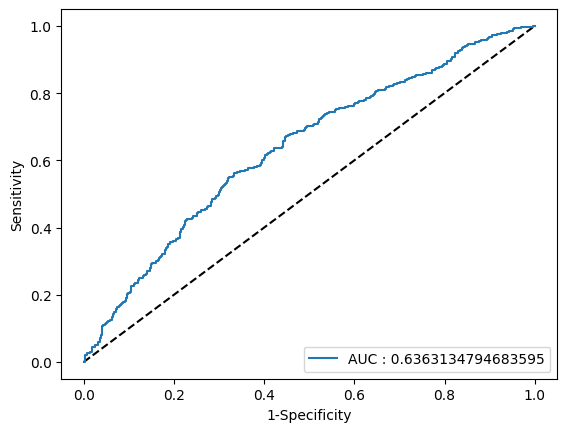

In [217]:
show_results(y_test, pred_mallight)

### Deep Mal (DL)

In [221]:
x_train_deepmal = np.concatenate([eaac_train, egaac_train, blo_train, dde_train, knn_train], axis=1)
x_test_deepmal = np.concatenate([eaac_test, egaac_test, blo_test, dde_test, knn_test], axis=1)

In [254]:
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)

sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph())
backend.set_session(sess)

DL = Sequential([
    Conv1D(filters = 64, kernel_size = 3, padding = 'same', activation= 'relu'),
    MaxPooling1D(pool_size = 4),
    Conv1D(filters = 128, kernel_size =  3, padding = 'same', activation= 'relu'),
    MaxPooling1D(pool_size = 4),
    Dropout(0.5),
    Flatten(),
    Dense(128, activation = 'relu',name="Dense_128"),
    Dense(64, activation = 'relu',name="Dense_64"),
    Dense(32, activation = 'relu',name="Dense_32"),
    Dense(2, activation = 'softmax',name="Dense_2")
])
DL.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics =['accuracy'])#rmsprop

In [255]:
DL.fit(x_train_deepmal.reshape(-1, 51, 37), to_categorical(y_train), epochs=50)

Epoch 1/50
264/264 [==============================] - 3s 8ms/step - loss: 0.6991 - accuracy: 0.4955
Epoch 2/50
264/264 [==============================] - 2s 7ms/step - loss: 0.6950 - accuracy: 0.4989
Epoch 3/50
264/264 [==============================] - 2s 7ms/step - loss: 0.6937 - accuracy: 0.4967
Epoch 4/50
264/264 [==============================] - 2s 7ms/step - loss: 0.6925 - accuracy: 0.5174
Epoch 5/50
264/264 [==============================] - 2s 7ms/step - loss: 0.6878 - accuracy: 0.5454
Epoch 6/50
264/264 [==============================] - 2s 7ms/step - loss: 0.6759 - accuracy: 0.5758
Epoch 7/50
264/264 [==============================] - 2s 7ms/step - loss: 0.6524 - accuracy: 0.6118
Epoch 8/50
264/264 [==============================] - 2s 7ms/step - loss: 0.6280 - accuracy: 0.6444
Epoch 9/50
264/264 [==============================] - 2s 7ms/step - loss: 0.6051 - accuracy: 0.6705
Epoch 10/50
264/264 [==============================] - 2s 6ms/step - loss: 0.5820 - accuracy: 0.6919

In [256]:
pred_deepmal_dl = DL.predict(x_test_deepmal.reshape(-1, 51, 37))

36/36 [==============================] - 0s 3ms/step


              precision    recall  f1-score   support

         0.0       0.64      0.60      0.62       568
         1.0       0.63      0.67      0.65       568

    accuracy                           0.63      1136
   macro avg       0.63      0.63      0.63      1136
weighted avg       0.63      0.63      0.63      1136

MCC : 0.2682065261023223
Kappa : 0.2676056338028169


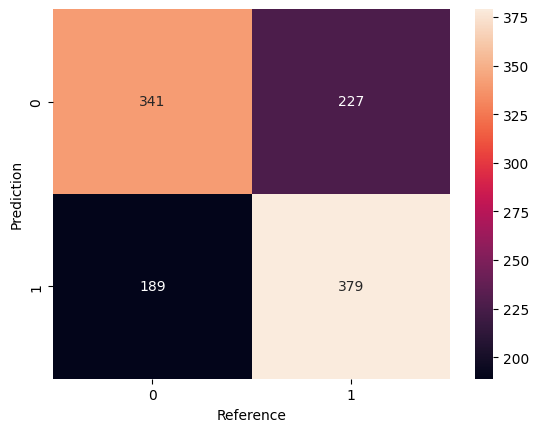

In [257]:
show_results(y_test, pred_deepmal_dl)

### Deep Mal (XGB)

In [258]:
xgb_deepmal = XGBClassifier(n_estimators=1000, max_depth=5, verbose=1, random_state=0)

In [259]:
xgb_deepmal.fit(x_train_deepmal, y_train)

[23:41:41] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "verbose" } are not used.



XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [260]:
pred_deepmal_xgb = xgb_deepmal.predict_proba(x_test_deepmal)

              precision    recall  f1-score   support

         0.0       0.77      0.66      0.71       568
         1.0       0.70      0.80      0.75       568

    accuracy                           0.73      1136
   macro avg       0.73      0.73      0.73      1136
weighted avg       0.73      0.73      0.73      1136

MCC : 0.46401704864327914
Kappa : 0.4595070422535211


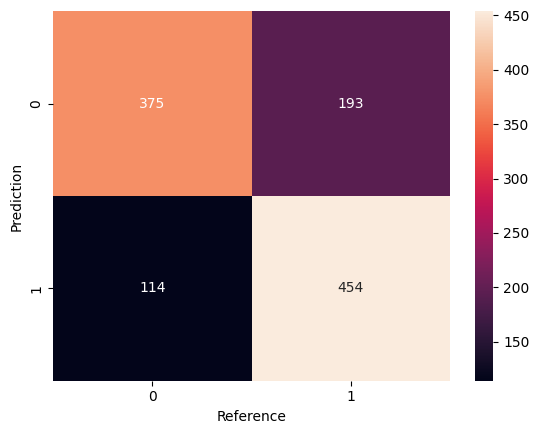

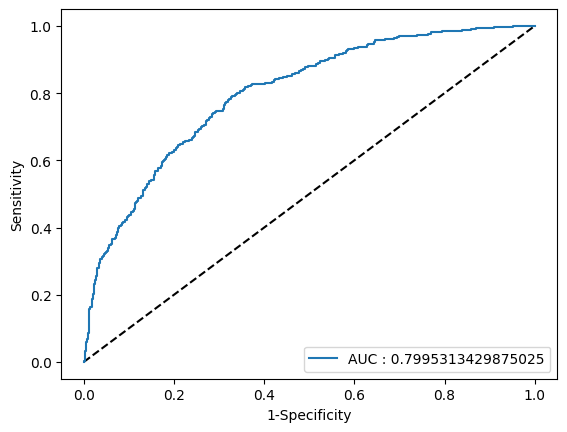

In [261]:
show_results(y_test, pred_deepmal_xgb)

### Kmalo

In [264]:
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)

sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph())
backend.set_session(sess)

model1 = Sequential(
    [
        Conv1D(filters = 51, kernel_size = 1, padding = 'same', activation= 'relu'),
        Dropout(0.5),
        Conv1D(filters = 21, kernel_size =  1, padding = 'same', activation= 'relu'),
        Dropout(0.5),
        Flatten(),
        Dense(128, activation = 'relu'),
        Dense(64, activation = 'relu'),
        Dense(2, activation = 'softmax')
    ]
)
model1.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics =['accuracy'])
model1.fit(bin_train.reshape(-1, 35, 20), to_categorical(y_train), epochs=50)
y_1 = model1.predict(bin_test.reshape(-1, 35, 20))

Epoch 1/50
264/264 [==============================] - 2s 6ms/step - loss: 0.6997 - accuracy: 0.5122
Epoch 2/50
264/264 [==============================] - 1s 6ms/step - loss: 0.6923 - accuracy: 0.5198
Epoch 3/50
264/264 [==============================] - 2s 6ms/step - loss: 0.6841 - accuracy: 0.5505
Epoch 4/50
264/264 [==============================] - 1s 6ms/step - loss: 0.6798 - accuracy: 0.5618
Epoch 5/50
264/264 [==============================] - 2s 6ms/step - loss: 0.6759 - accuracy: 0.5704
Epoch 6/50
264/264 [==============================] - 1s 5ms/step - loss: 0.6696 - accuracy: 0.5903
Epoch 7/50
264/264 [==============================] - 2s 6ms/step - loss: 0.6682 - accuracy: 0.5842
Epoch 8/50
264/264 [==============================] - 1s 5ms/step - loss: 0.6642 - accuracy: 0.5917
Epoch 9/50
264/264 [==============================] - 1s 6ms/step - loss: 0.6609 - accuracy: 0.5956
Epoch 10/50
264/264 [==============================] - 1s 6ms/step - loss: 0.6544 - accuracy: 0.6164

In [265]:
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)

sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph())
backend.set_session(sess)

model2 = Sequential(
    [
        Conv1D(filters = 200, kernel_size = 1, padding = 'same', activation= 'relu'),
        MaxPooling1D(pool_size = 2),
        Dropout(0.5),
        Conv1D(filters = 100, kernel_size =  1, padding = 'same', activation= 'relu'),
        MaxPooling1D(pool_size = 2),
        Dropout(0.5),
        Flatten(),
        Dense(128, activation = 'relu'),
        Dense(64, activation = 'relu'),
        Dense(2, activation = 'softmax')
    ]
)
model2.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics =['accuracy'])
model2.fit(pcp_train.reshape(-1, 35, 16), to_categorical(y_train), epochs=50)
y_2 = model2.predict(pcp_test.reshape(-1, 35, 16))

Epoch 1/50
264/264 [==============================] - 3s 9ms/step - loss: 0.6959 - accuracy: 0.5249
Epoch 2/50
264/264 [==============================] - 2s 9ms/step - loss: 0.6796 - accuracy: 0.5713
Epoch 3/50
264/264 [==============================] - 3s 10ms/step - loss: 0.6740 - accuracy: 0.5800
Epoch 4/50
264/264 [==============================] - 3s 10ms/step - loss: 0.6626 - accuracy: 0.6010
Epoch 5/50
264/264 [==============================] - 3s 11ms/step - loss: 0.6447 - accuracy: 0.6227
Epoch 6/50
264/264 [==============================] - 2s 9ms/step - loss: 0.6298 - accuracy: 0.6471
Epoch 7/50
264/264 [==============================] - 2s 9ms/step - loss: 0.6155 - accuracy: 0.6572
Epoch 8/50
264/264 [==============================] - 3s 10ms/step - loss: 0.6086 - accuracy: 0.6692
Epoch 9/50
264/264 [==============================] - 3s 10ms/step - loss: 0.6076 - accuracy: 0.6663
Epoch 10/50
264/264 [==============================] - 3s 10ms/step - loss: 0.5992 - accuracy: 

In [267]:
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)

sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph())
backend.set_session(sess)

model3 = Sequential(
    [
        Conv1D(filters = 100, kernel_size = 1, padding = 'same', activation= 'relu'),
        MaxPooling1D(pool_size = 2),
        Dropout(0.5),
        Conv1D(filters = 50, kernel_size =  1, padding = 'same', activation= 'relu'),
        MaxPooling1D(pool_size = 2),
        Dropout(0.5),
        Flatten(),
        Dense(128, activation = 'relu'),
        Dense(64, activation = 'relu'),
        Dense(2, activation = 'softmax')
    ]
)
model3.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics =['accuracy'])
model3.fit(pssm_train.reshape(-1, 35, 20).astype('float32'), to_categorical(y_train), epochs=50)
y_3 = model3.predict(pssm_test.reshape(-1, 35, 20).astype('float32'))

Epoch 1/50
264/264 [==============================] - 3s 8ms/step - loss: 0.6901 - accuracy: 0.5563
Epoch 2/50
264/264 [==============================] - 2s 6ms/step - loss: 0.6720 - accuracy: 0.5809
Epoch 3/50
264/264 [==============================] - 2s 8ms/step - loss: 0.6662 - accuracy: 0.5906
Epoch 4/50
264/264 [==============================] - 2s 8ms/step - loss: 0.6627 - accuracy: 0.5916
Epoch 5/50
264/264 [==============================] - 2s 7ms/step - loss: 0.6571 - accuracy: 0.6025
Epoch 6/50
264/264 [==============================] - 2s 7ms/step - loss: 0.6539 - accuracy: 0.6077
Epoch 7/50
264/264 [==============================] - 2s 7ms/step - loss: 0.6516 - accuracy: 0.6127
Epoch 8/50
264/264 [==============================] - 2s 7ms/step - loss: 0.6480 - accuracy: 0.6185
Epoch 9/50
264/264 [==============================] - 2s 7ms/step - loss: 0.6482 - accuracy: 0.6179
Epoch 10/50
264/264 [==============================] - 2s 7ms/step - loss: 0.6496 - accuracy: 0.6129

In [268]:
model4 = RandomForestClassifier(n_estimators=1000, verbose=1, random_state=0)
model4.fit(aac_train, y_train)
y_4 = model4.predict_proba(aac_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   12.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished


In [269]:
model5 = RandomForestClassifier(n_estimators=1000, verbose=1, random_state=0)
model5.fit(paac_train.iloc[:, :-1], paac_train.iloc[:, -1])
y_5 = model5.predict_proba(paac_test.iloc[:, :-1])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   45.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished


In [271]:
y_1_train = model1.predict(bin_train.reshape(-1, 35, 20))
y_2_train = model2.predict(pcp_train.reshape(-1, 35, 16))
y_3_train = model3.predict(pssm_train.reshape(-1, 35, 20).astype('float32'))
y_4_train = model4.predict_proba(aac_train)
y_5_train = model5.predict_proba(paac_train.iloc[:, :-1])

Y_train = np.array([y_1_train[:, 1], y_2_train[:, 1], y_3_train[:, 1], y_4_train[:, 1], y_5_train[:, 1]]).T
Y_test = np.array([y_1[:, 1], y_2[:, 1], y_3[:, 1], y_4[:, 1], y_5[:, 1]]).T

264/264 [==============================] - 1s 3ms/step


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    2.0s finished


In [272]:
svm = SVC(kernel='linear', C=1, probability=True)
svm.fit(Y_train, y_train)
pred_kmalo = svm.predict_proba(Y_test)

              precision    recall  f1-score   support

         0.0       0.74      0.62      0.67       568
         1.0       0.67      0.78      0.72       568

    accuracy                           0.70      1136
   macro avg       0.71      0.70      0.70      1136
weighted avg       0.71      0.70      0.70      1136

MCC : 0.4053577891551535
Kappa : 0.39964788732394363


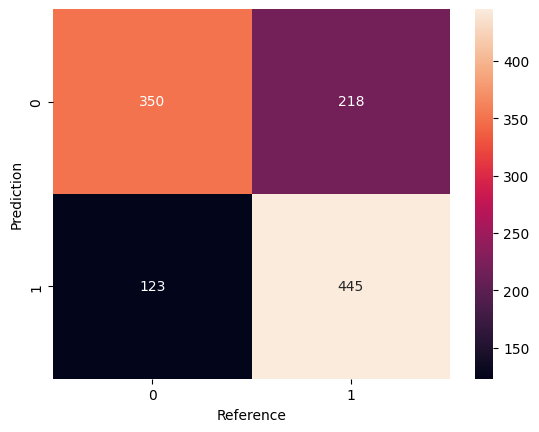

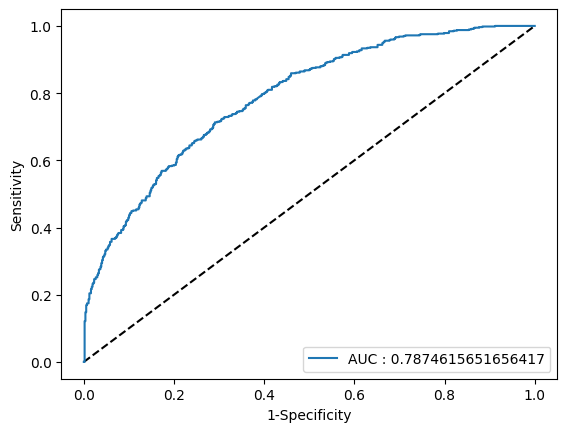

In [273]:
show_results(y_test, pred_kmalo)

### SEMal

In [274]:
def get_profile_bigram(PSSM, flatten = False, WINDOW_SIZE=35):
    B = [[0 for x in range(20)] for y in range(20)]
    for p in range(20):
        for q in range(20):
            now = 0
            for k in range(WINDOW_SIZE - 1):
                now += PSSM[k][p] * PSSM[k + 1][q]
            B[p][q] = now

    return np.asarray(B).flatten() if flatten else B

In [275]:
bigram_train = []
bigram_test = []

for i, p in enumerate(pssm_train.reshape(-1, 35, 20)):
    print(i)
    PSSM_bigram = get_profile_bigram(p, True)  # 20 x 20
    bigram_train.append(PSSM_bigram)

for i, p in enumerate(pssm_test.reshape(-1, 35, 20)):
    print(i)
    PSSM_bigram = get_profile_bigram(p, True)  # 20 x 20
    bigram_test.append(PSSM_bigram)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [276]:
bigram_train = np.array(bigram_train)
bigram_test = np.array(bigram_test)

In [280]:
rotation_f = RotationForestClassifier(n_estimators=100, verbose=4, random_state=0)
rotation_f.fit(bigram_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s remaining:    0.0s


building tree 2 of 100


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.0s remaining:    0.0s


building tree 3 of 100


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   13.5s remaining:    0.0s


building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 10

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  7.3min finished


RotationForestClassifier(n_estimators=100, random_state=0, verbose=4)

In [281]:
pred_semal = rotation_f.predict_proba(bigram_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


              precision    recall  f1-score   support

         0.0       0.55      0.51      0.53       568
         1.0       0.55      0.58      0.56       568

    accuracy                           0.55      1136
   macro avg       0.55      0.55      0.55      1136
weighted avg       0.55      0.55      0.55      1136

MCC : 0.09706004938206726
Kappa : 0.096830985915493


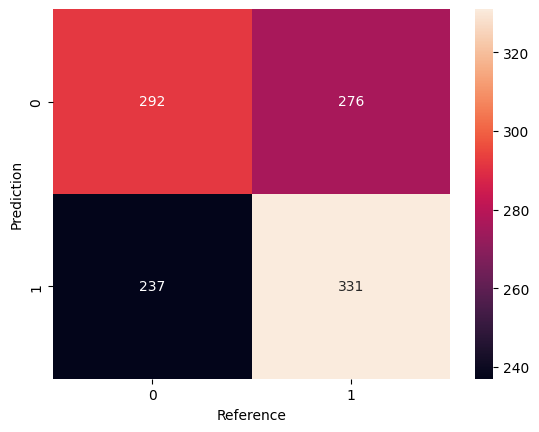

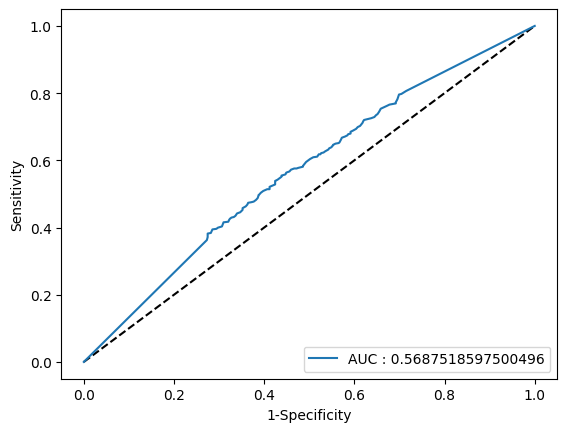

In [282]:
show_results(y_test, pred_semal)

### Kmal-sp

In [283]:
x_train_kmalsp = np.concatenate([x_train, knn_train], axis=1)
x_test_kmalsp = np.concatenate([x_test, knn_test], axis=1)

In [285]:
pca = PCA(n_components=100)
pca.fit(x_train_kmalsp)
x_train_kmalsp = pca.transform(x_train_kmalsp)
x_test_kmalsp = pca.transform(x_test_kmalsp)

In [287]:
baseSVM = SVC(verbose=1, random_state=0)

params = {
    'C': [2e-10, 2e-8, 2e-6, 2e-4, 2e-2, 1, 2e2, 2e4],
    'gamma': [2e-10, 2e-8, 2e-6, 2e-4, 2e-2, 1, 2e2, 2e4],
    'kernel': ['rbf']
}

searchSVM = GridSearchCV(baseSVM, params, cv=3, verbose=1)

In [288]:
searchSVM.fit(x_train_kmalsp, y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][L

GridSearchCV(cv=3, estimator=SVC(random_state=0, verbose=1),
             param_grid={'C': [2e-10, 2e-08, 2e-06, 0.0002, 0.02, 1, 200.0,
                               20000.0],
                         'gamma': [2e-10, 2e-08, 2e-06, 0.0002, 0.02, 1, 200.0,
                                   20000.0],
                         'kernel': ['rbf']},
             verbose=1)

In [289]:
searchSVM.best_params_

{'C': 20000.0, 'gamma': 2e-06, 'kernel': 'rbf'}

In [290]:
from lightgbm import LGBMClassifier
baseGBM = LGBMClassifier(verbose=2, random_state=0)

params = {
    'learning_rate': [0.001, 0.001, 0.1, 1, 10],
    'num_leaves': [1, 3, 5, 7, 10]
}

searchGBM = GridSearchCV(baseGBM, params, cv=3, verbose=1)

In [291]:
searchGBM.fit(x_train_kmalsp, y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[LightGBM] [Info] Number of positive: 2814, number of negative: 2814
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.000000
[LightGBM] [Debug] init for col-wise cost 0.000270 seconds, init for row-wise cost 0.002003 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 5628, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Debug] Trained a tree with leaves = 3 and depth = 2
[LightGBM] [Debug] Trained a tree with leaves = 3 and depth = 2
[LightGBM] [Debug] Trained a tree with leaves = 3 and depth = 2
[LightGBM] [Debug] Trained a tree with leaves = 3 and depth = 2
[LightGBM] [Debug] Trained a tree with leaves = 3 and depth = 2
[

c:\Python310\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Python310\lib\site-packages\lightgbm\sklearn.py", line 1142, in fit
    super().fit(
  File "c:\Python310\lib\site-packages\lightgbm\sklearn.py", line 842, in fit
    self._Booster = train(
  File "c:\Python310\lib\site-packages\lightgbm\engine.py", line 245, in train
    booster = Booster(params=params, train_set=train_s

[LightGBM] [Info] Number of positive: 4221, number of negative: 4221
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.000000
[LightGBM] [Debug] init for col-wise cost 0.000010 seconds, init for row-wise cost 0.002353 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 8442, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 10 and de

GridSearchCV(cv=3, estimator=LGBMClassifier(random_state=0, verbose=2),
             param_grid={'learning_rate': [0.001, 0.001, 0.1, 1, 10],
                         'num_leaves': [1, 3, 5, 7, 10]},
             verbose=1)

In [292]:
searchGBM.best_params_

{'learning_rate': 0.1, 'num_leaves': 10}

In [293]:
from sklearn.neighbors import KNeighborsClassifier
baseKNN = KNeighborsClassifier()

params = {
    'n_neighbors': list(range(1, 101)),
    'leaf_size': list(range(1, 11))
}

searchKNN = GridSearchCV(baseKNN, params, cv=3, verbose=1)

In [294]:
searchKNN.fit(x_train_kmalsp, y_train)

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...]},
             verbose=1)

In [295]:
searchKNN.best_params_

{'leaf_size': 1, 'n_neighbors': 100}

In [296]:
from sklearn.linear_model import LogisticRegression
baseLR = LogisticRegression(verbose=1, random_state=0)

params = {
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'dual': [True, False],
    'C': [0.001, 0.01, 0.1, 1, 10],
    'fit_intercept': [True, False],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
}

searchLR = GridSearchCV(baseLR, params, cv=3, verbose=1)

In [297]:
searchLR.fit(x_train_kmalsp, y_train)

Fitting 3 folds for each of 480 candidates, totalling 1440 fits
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 15 epochs took 0 seconds
convergence after 14 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 15 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


[LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 24 epochs took 1 seconds
convergence after 22 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 22 epochs took 0 seconds
convergence after 18 epochs took 0 seconds
convergence after 18 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 17 epochs took 0 seconds
[LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


[LibLinear]convergence after 15 epochs took 1 seconds


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 14 epochs took 0 seconds
convergence after 12 epochs took 0 seconds
[LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


[LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 24 epochs took 1 seconds
convergence after 22 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 22 epochs took 0 seconds
convergence after 18 epochs took 0 seconds
convergence after 18 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 17 epochs took 0 seconds
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 19 epochs took 0 seconds
convergence after 18 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 18 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


convergence after 35 epochs took 0 seconds
convergence after 36 epochs took 1 seconds


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 35 epochs took 0 seconds
convergence after 19 epochs took 0 seconds
convergence after 19 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 19 epochs took 0 seconds
[LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 19 epochs took 1 seconds
convergence after 18 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 18 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


convergence after 35 epochs took 0 seconds
convergence after 36 epochs took 0 seconds


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 35 epochs took 0 seconds
convergence after 19 epochs took 0 seconds
convergence after 19 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 19 epochs took 1 seconds
[LibLinear][LibLinear][LibLinear][LibLinear]

c:\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

c:\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

c:\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear][LibLinear][LibLinear][LibLinear]

c:\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

c:\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

c:\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 19 epochs took 0 seconds
convergence after 19 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 19 epochs took 0 seconds
[LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


[LibLinear]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 40 epochs took 1 seconds
convergence after 40 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 39 epochs took 0 seconds
convergence after 19 epochs took 0 seconds
convergence after 20 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 19 epochs took 0 seconds
[LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 19 epochs took 0 seconds
convergence after 19 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 19 epochs took 0 seconds
[LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


[LibLinear]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 40 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 39 epochs took 0 seconds
convergence after 39 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 19 epochs took 0 seconds
convergence after 19 epochs took 1 seconds


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 19 epochs took 0 seconds
[LibLinear][LibLinear][LibLinear][LibLinear]

c:\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

c:\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

c:\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear][LibLinear][LibLinear][LibLinear]

c:\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

c:\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

c:\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 19 epochs took 0 seconds
convergence after 20 epochs took 1 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 19 epochs took 0 seconds
[LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


[LibLinear]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 41 epochs took 0 seconds
convergence after 40 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 40 epochs took 0 seconds
convergence after 19 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 20 epochs took 0 seconds
convergence after 19 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


[LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 19 epochs took 0 seconds
convergence after 19 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 19 epochs took 0 seconds
[LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 41 epochs took 0 seconds
convergence after 40 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 40 epochs took 1 seconds
convergence after 19 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 19 epochs took 0 seconds
convergence after 19 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


[LibLinear][LibLinear][LibLinear][LibLinear]

c:\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

c:\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

c:\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear][LibLinear][LibLinear][LibLinear]

c:\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

c:\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

c:\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 19 epochs took 1 seconds
convergence after 20 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 19 epochs took 0 seconds
[LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


[LibLinear]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 41 epochs took 0 seconds
convergence after 40 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 40 epochs took 0 seconds
convergence after 19 epochs took 1 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 20 epochs took 0 seconds
convergence after 19 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


[LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 19 epochs took 0 seconds
convergence after 19 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 19 epochs took 1 seconds
[LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


[LibLinear]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 41 epochs took 1 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 40 epochs took 0 seconds
convergence after 40 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 19 epochs took 0 seconds
convergence after 19 epochs took 0 seconds


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 19 epochs took 0 seconds
[LibLinear]

c:\Python310\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
1200 fits failed out of a total of 1440.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py", line 61, in _check_solver
    raise ValueError(
ValueError: Solver lbfgs supports only 'l2' or 'n

GridSearchCV(cv=3, estimator=LogisticRegression(random_state=0, verbose=1),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'dual': [True, False],
                         'fit_intercept': [True, False],
                         'penalty': ['l1', 'l2', 'elasticnet', None],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                    'newton-cholesky', 'sag', 'saga']},
             verbose=1)

In [298]:
searchLR.best_params_

{'C': 0.01,
 'dual': True,
 'fit_intercept': True,
 'penalty': 'l2',
 'solver': 'liblinear'}

In [310]:
svm = SVC(C=20000, gamma=2e-6, kernel='rbf', verbose=1, probability=True, random_state=0)
rf = RandomForestClassifier(n_estimators=1000, verbose=1, random_state=0)
gbm = LGBMClassifier(learning_rate=0.1, num_leaves=10, verbose=2, random_state=0)
knn = KNeighborsClassifier(n_neighbors=100, leaf_size=1)
lr = LogisticRegression(C=0.01, dual=True, fit_intercept=True, penalty='l2', solver='liblinear', verbose=1, random_state=0)

In [311]:
svm.fit(x_train_kmalsp, y_train)
rf.fit(x_train_kmalsp, y_train)
gbm.fit(x_train_kmalsp, y_train)
knn.fit(x_train_kmalsp, y_train)
lr.fit(x_train_kmalsp, y_train)

[LibSVM]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  1.1min finished


[LightGBM] [Info] Number of positive: 4221, number of negative: 4221
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.000000
[LightGBM] [Debug] init for col-wise cost 0.000011 seconds, init for row-wise cost 0.002495 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 8442, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 10 and de

LogisticRegression(C=0.01, dual=True, random_state=0, solver='liblinear',
                   verbose=1)

In [312]:
y_svm = svm.predict_proba(x_test_kmalsp)
y_rf = rf.predict_proba(x_test_kmalsp)
y_gbm = gbm.predict_proba(x_test_kmalsp)
y_knn = knn.predict_proba(x_test_kmalsp)
y_lr = lr.predict_proba(x_test_kmalsp)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished


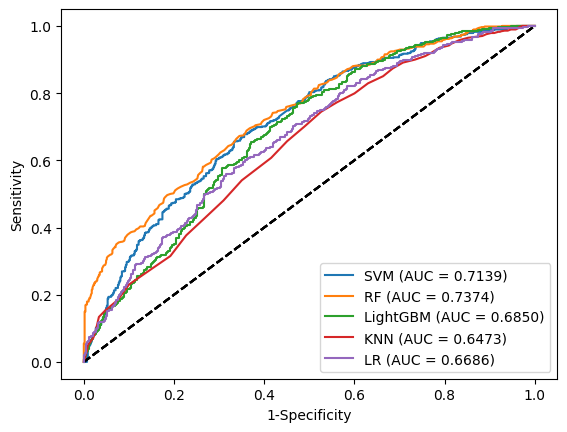

In [313]:
preds = [
    ['SVM', y_svm],
    ['RF', y_rf],
    ['LightGBM', y_gbm],
    ['KNN', y_knn],
    ['LR', y_lr]
]

ROC_AUC_PLOT_ALL(y_test, preds)

In [314]:
pred_kmalsp = np.mean([y_rf, y_svm], axis=0)

              precision    recall  f1-score   support

         0.0       0.71      0.56      0.63       568
         1.0       0.64      0.77      0.70       568

    accuracy                           0.67      1136
   macro avg       0.67      0.67      0.66      1136
weighted avg       0.67      0.67      0.66      1136

MCC : 0.338368194884451
Kappa : 0.33098591549295775


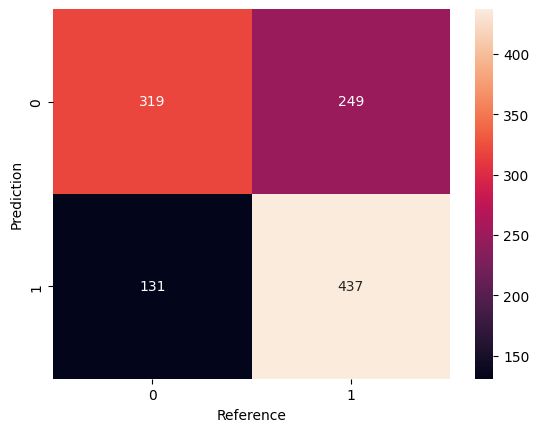

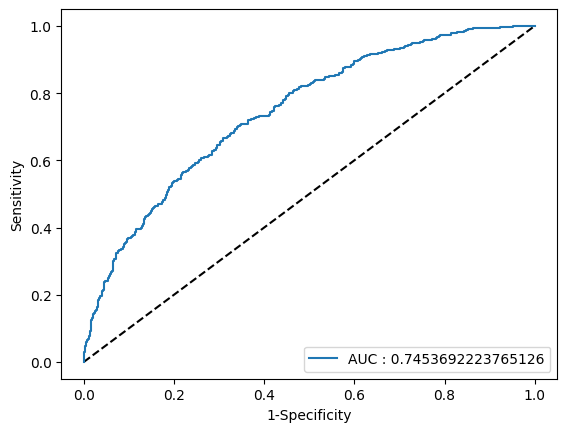

In [315]:
show_results(y_test, pred_kmalsp)

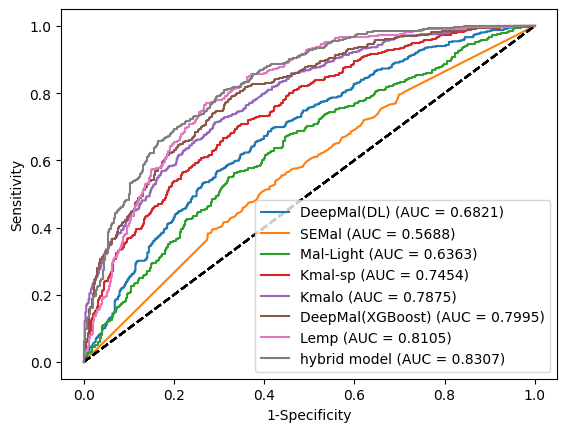

In [316]:
preds = [
    ['DeepMal(DL)', pred_deepmal_dl],
    ['SEMal', pred_semal],
    ['Mal-Light', pred_mallight],
    ['Kmal-sp', pred_kmalsp],
    ['Kmalo', pred_kmalo],
    ['DeepMal(XGBoost)', pred_deepmal_xgb],
    ['Lemp', pred_lemp],
    ['hybrid model', pred_hybrid]
]

ROC_AUC_PLOT_ALL(y_test, preds)

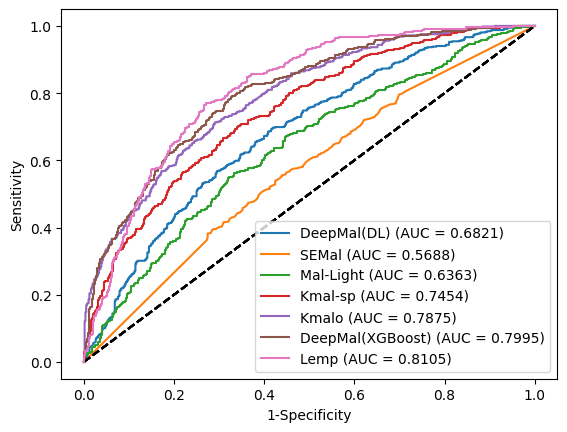

In [317]:
preds = [
    ['DeepMal(DL)', pred_deepmal_dl],
    ['SEMal', pred_semal],
    ['Mal-Light', pred_mallight],
    ['Kmal-sp', pred_kmalsp],
    ['Kmalo', pred_kmalo],
    ['DeepMal(XGBoost)', pred_deepmal_xgb],
    ['Lemp', pred_lemp]
]

ROC_AUC_PLOT_ALL(y_test, preds)